# Introduction
ABCGAN (atmospheric TEC wave characterization 'wTEC') is a generative adversarial network that reproduces realistic atmospheric perturbations in the ionosphere derived from GNSS TEC measurements. Unlike traditional empirical models, ABCGAN can produce not only the average atmospheric waves/perturbations under particular conditions, but also the expected distribution of parameters. This allows the GAN to estimate the probability that a given atmospheric perturbation is part of the historical distribution, enabling it to determine if an event is highly unusual (outside the range of "normal" atmospheric variation).

The TEC models are trained on historical waves derived from measurements collected around various locations including Poker Flat, Mt Moses, Colorado, New Mexico, Oklahoma, and Texas. Each of the datasets span from 2010-2020. TEC data consists of wave parameters derived from various nearby GNSS station measurements. For more information about the training data, visit amisr.com.

# Tutorial Outline

ABCGAN machine learning methods can be applied to characterize the atmosphere using alternative more globally available data sources. Specifically, in this demo we will show how we can use the same machine learning techniques to characterize atmospheric waves derived from TEC measurements collected from various GNSS stations across multiple locations. We will also explore how well our methods generalizes by training a regional model designed to charaterize TEC waves across multiple locations. Easy access to the  more globally available TEC data makes these regional models possible and in theory, these TEC waves can be derived for any location which has nearby GNSS stations and be used to train global model.

* Import ABCGAN
* TEC Waves
* External Drivers
* TEC Datasets
* Loading & Exploring Data
* wTEC GAN
    * Generating TEC Waves
    * Evaluating Model
* TEC Wave Anomaly Scores
* Regional Model
* WTEC Context Model

# Import ABCGAN & Python Modules

Several imports are used. In particular, we load `numpy`, which provides the formats for data input output. We also use the numpy library for calculation of statistics and simulating fake data. We load `abcgan` which contains modules for generating atmospheric data, evaluating model performing, estimating anomaly scores, and analysing model behaviors. We also load `matplotlib.pyplot`, `seaborn`, and `pandas` for display.

In [1]:
import numpy as np  # numerics
import matplotlib.pyplot as plt  # plotting
import seaborn as sns  # plotting
import pandas as pd  # plotting
import datetime
import abcgan.constants as const
from abcgan.anomaly import anomaly_score_wtec
from abcgan.interface import load_wtec_h5, generate_wtec, generate_multi_wtec
from abcgan.evaluate import hellinger_scores_wtec, conditional_wtec_scores
import plotting_utils as util
import tqdm

# TEC Waves

The TEC Wave (wTEC) data consists of samples containing wave parameters that describe traveling ionospheric disturbances/perturbations, i.e. atmospheric waves. These waves are derived from GNSS measurements collected from various nearby stations. The Specific wave parameters are listed in the chat below. Each wave parameter also contains a max, median, and min feature found over an hour-long window giving a total of 18 features per sample or hour.

| Key    | Description                           | Units         |
|--------|---------------------------------------|---------------|
| uAmp   | Detrended TEC Amplitude               | uTEC          |
| Amp    | TEC Amplitude                         | uTEC          |
| Tau    | Period                                | minutes       |
| Lambda | Wavelength                            | meters        |
| C1     | Horizontal Wave Speed                 | meters/second |
| Phi    | Horizontal Wave Propagation Direction | degrees       |


## External Drivers

Our models take the external drivers, which describe the current environmental conditions, and outputs generated TEC wave parameters. We currently are using 31 external drivers. The list of drivers keys printed above corresponds to the following physical parameters:

| Key               | Full Name                      | Description                                                                                                |
|-------------------|--------------------------------|------------------------------------------------------------------------------------------------------------|
| SLT               | Solar Local Time               | Local time as determined by the sun's position                                                             |
| MLT               | Magnetic Local Time            | Local time calculated used magnetic coordinate system                                                      |
| SZA               | Solar Zenith Angle             | Angle between the sun and local zenith                                                                     |
| ShadHeight        | Shadow Height                  | Height of the Earth's shadow in the atmosphere                                                             |
| moon_x            | Lunar Position - x             | X component of Lunar position in ECEF coordinates                                                          |
| moon_y            | Lunar Position - y             | Y component of Lunar position in ECEF coordinates                                                          |
| moon_z            | Lunar Position - z             | Z component of Lunar position in ECEF coordinates                                                          |
| moon_phase        | Lunar Phase                    | Lunar phase in degrees                                                                                     |
| ap                | ap Geomagnetic Index           | Three hour equivilent planetary amplitude                                                                  |
| Ap                | Daily Ap Index                 | Daily equivalent planetary aplitude                                                                        |
| F10.7             | F10.7 Solar Radio Flux         | Solar rado flux at 10.7 cm (2800 MHz) in s.f.u (10^-22 W m^-2 Hz^-1)                                       |
| F10.7a            | Average F10.7 Solar Radio Flux | Average solar rado flux at 10.7 cm (2800 MHz) in s.f.u (10^-22 W m^-2 Hz^-1)                               |
| TCI               | Thermosphere Climate Index     | 60-day running average of global cooling power radiated from the thermosphere                              |
| MEI               | Multivariate ESNO Index        | Measure of the El Nino/Southern Oscillation (ESNO)/sea surface temperature                                 |
| RMM1              | First MJO Index                | First component of the Madden-Julian Osscillation Indices                                                  |
| RMM2              | Second MJO Index               | Second component of the Madden-Julian Osscillation Indices                                                 |
| U2/5/10/30/70/100 | Mean zonal winds               | mean zonal winds (eastward) at at altitudes with pressures 2,5,10,30,70, and 100 hPa                       |
| T2/5/10/30/70/100 | Mean Stratospheric Temps       | Stratospheric northern hemisphere mean (60 - 90 lat) at altitudes with pressures 2,5,10,30,70, and 100 hPa |
| dst               | Distrurbance storm time index  | index of magnetic activity that measures the intensity of the globally symmetrical equatorial electrojet   |
| MLAT              | Latitude                       | latitude in degrees of the sample's location                                                               |
| MLON              | Longitude                      | longitude in degrees of the sample's location                                                              |


# TEC Datasets

The data team have created various wTEC datasets across a wide range of location that we are trying to characterize. Each dataset for a specific location contains the wave parameters found across a specific band of frequencies. Currently, we have data for characterizing TEC waves over Poker Flat, Alaska, Mt Moses and spaceports in Nevada, Colorado, New Mexico, Houston, Midland, and Oklahoma. Below shows the different datasets and models we currently have.

| Dataset Name       | TID Type                                                 | Wave Period Ranges | Location                              |
|--------------------|----------------------------------------------------------|--------------------|---------------------------------------|
| TSTIDs_PFRR        | Tiny-scale traveling ionospheric disturbances   (TSTIDs) | 100-500 Seconds    | Poker Flat Rocket Range, Alaska       |
| SSTIDs_PFRR        | Small-scale traveling ionospheric disturbances  (SSTIDs) | 300-900 Seconds    | Poker Flat Rocket Range, Alaska       |
| MSTIDs_PFRR        | Medium-scale traveling ionospheric disturbances (MSTIDs) | 900-3600 Seconds   | Poker Flat Rocket Range, Alaska       |
| LSTIDs_PFRR        | Large-scale traveling ionospheric disturbances  (LSTIDs) | 3600-7200 Seconds  | Poker Flat Rocket Range, Alaska       |
| -                  | --                                                       | -                  | -                                     |
| MSTIDs_MtMoses     | Medium-scale traveling ionospheric disturbances (MSTIDs) | 900-3600 Seconds   | Mt. Moses, Nevada                     |
| LSTIDs_MtMoses     | Large-scale traveling ionospheric disturbances  (LSTIDs) | 3600-7200 Seconds  | Mt. Moses, Nevada                     |
| -                  | --                                                       | -                  | -                                     |
| TSTIDs_ColoradoCFO | Tiny-scale traveling ionospheric disturbances   (TSTIDs) | 100-500 Seconds    | Colorado Air and Space Port, Colorado |
| SSTIDs_ColoradoCFO | Small-scale traveling ionospheric disturbances  (SSTIDs) | 300-900 Seconds    | Colorado Air and Space Port, Colorado |
| -                  | --                                                       | -                  | -                                     |
| TSTIDs_OklahomaCSM | Tiny-scale traveling ionospheric disturbances   (TSTIDs) | 100-500 Seconds    | Clinton Sherman Spaceport, Oklahoma   |
| SSTIDs_OklahomaCSM | Small-scale traveling ionospheric disturbances  (SSTIDs) | 300-900 Seconds    | Clinton Sherman Spaceport, Oklahoma   |
| -                  | --                                                       | -                  | -                                     |
| TSTIDs_HoustonTxSS | Tiny-scale traveling ionospheric disturbances   (TSTIDs) | 100-500 Seconds    | Houston Space Port, Texas             |
| SSTIDs_HoustonTxSS | Small-scale traveling ionospheric disturbances  (SSTIDs) | 300-900 Seconds    | Houston Space Port, Texas             |
| -                  | --                                                       | -                  | -                                     |
| TSTIDs_MidlandTxSS | Tiny-scale traveling ionospheric disturbances   (TSTIDs) | 100-500 Seconds    | Midland Space Port, Texes             |
| SSTIDs_MidlandTxSS | Small-scale traveling ionospheric disturbances  (SSTIDs) | 300-900 Seconds    | Midland Space Port, Texes             |
| -                  | --                                                       | -                  | -                                     |
| TSTIDs_NMExicoSPA  | Tiny-scale traveling ionospheric disturbances   (TSTIDs) | 100-500 Seconds    | Space Port America, New Mexico        |
| SSTIDs_NMExicoSPA  | Small-scale traveling ionospheric disturbances  (SSTIDs) | 300-900 Seconds    | Space Port America, New Mexico        |


# Loading & Exploring Data

#### Example 1: SSTIDs, Poker Flat

Below shows an example of how we can load the data for a specific location (Poker Flat, i.e. PFRR) and TID Type (SSTIDs). The data is loaded by using the `load_wtec_h5` function. By default, the function will load data from a tutorial data file, which contains all the datasets listed in the chat above. Each dataset contains over 60,0000 samples ranging 2010-2020 of TEC wave parameters and geophysical Drivers. Other datasets can be loaded by simply changing the `locations` and `tid_type` input argument. For example to load ColoradoCFO  Tiny Scale TIDs (TSTIDs) set `location="ColoradoCFO"` and `tid_type="SSTIDs"`. The data returned from the loader is a dictionary containing the TEC waves, drivers, and other metadata. The TEC waves and drivers are arrays with structure (n_samples, n_features).

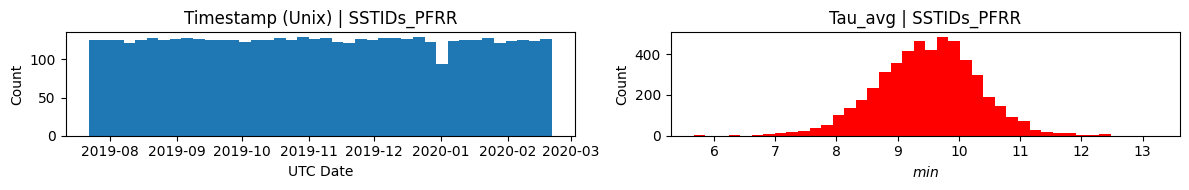

Output Data Structure:
    First Layer: ['PFRR']
        Second Layer: ['drivers: (5000, 31)', 'wtecs: (5000, 18)', 'ctx_wtecs: (5000, 0, 18)', 'utc: (5000,)', 'location: PFRR', 'tid_type: SSTIDs', 'dataset_name: SSTIDs_PFRR']



In [2]:
# Select location and TID type to load
location = 'PFRR'
tid_type = "SSTIDs"
dataset_name = f'{tid_type}_{location}'

# Load 5,000 samples and print data struct
data = load_wtec_h5(tid_type=tid_type, locations=location, n_samples=5000, start_utc='random')

# Plot distribution of sample timestamps
wtec_index = 7 ## Avg Wave Period
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
ax[0].hist([datetime.datetime.utcfromtimestamp(t) for t in data[location]["utc"]], bins=40)
ax[0].set_ylabel("Count")
ax[0].set_title(f'Timestamp (Unix) | {dataset_name}')
ax[0].set_xlabel('UTC Date')
ax[1].hist(data[location]["wtecs"][:, wtec_index], bins=40, color="red")
ax[1].set_ylabel("Count")
ax[1].set_xlabel(const.wtec_units[wtec_index])
ax[1].set_title(f'{const.wtec_names[wtec_index]} | {dataset_name}')
plt.tight_layout()
plt.show()
plt.close(fig)
print(f'Output Data Structure:\n'
      f'    First Layer: {list(data.keys())}\n'
      f'        Second Layer: {[f"{k}: {d.shape}" if isinstance(d, np.ndarray) else f"{k}: {d}" for k, d in data[location].items()]}\n')

#### Example 2: TSTIDs, Houston
We can also load in Tiny scale TIDs using the same function and simply changing the TID type input argument, i.e. `tid_type="TSTIDs"`. Tiny scale TIDs have the same features as Small scale TIDs, however contains a slightly higher frequency wave parameters.

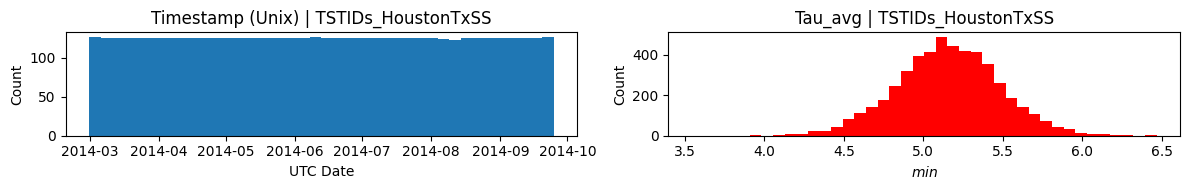

Output Data Structure:
    First Layer: ['HoustonTxSS']
        Second Layer: ['drivers: (5000, 31)', 'wtecs: (5000, 18)', 'ctx_wtecs: (5000, 0, 18)', 'utc: (5000,)', 'location: HoustonTxSS', 'tid_type: TSTIDs', 'dataset_name: TSTIDs_HoustonTxSS']



In [3]:
# Select location and TID type to load
location = 'HoustonTxSS'
tid_type = "TSTIDs"
dataset_name = f'{tid_type}_{location}'

# Load 5,000 samples and print data struct
data = load_wtec_h5(tid_type=tid_type, locations=location, n_samples=5000, start_utc='random')

# Plot distribution of sample timestamps
wtec_index = 7 ## Avg Wave Period
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
ax[0].hist([datetime.datetime.utcfromtimestamp(t) for t in data[location]["utc"]], bins=40)
ax[0].set_ylabel("Count")
ax[0].set_xlabel('UTC Date')
ax[0].set_title(f'Timestamp (Unix) | {dataset_name}')
ax[1].hist(data[location]["wtecs"][:, wtec_index], bins=40, color="red")
ax[1].set_ylabel("Count")
ax[1].set_xlabel(const.wtec_units[wtec_index])
ax[1].set_title(f'{const.wtec_names[wtec_index]} | {dataset_name}')
plt.tight_layout()
plt.show()
plt.close(fig)
print(f'Output Data Structure:\n'
      f'    First Layer: {list(data.keys())}\n'
      f'        Second Layer: {[f"{k}: {d.shape}" if isinstance(d, np.ndarray) else f"{k}: {d}" for k, d in data[location].items()]}\n')

### Loading Multiple Locations (SSTIDs)

We can also load all the locations we currently have for a specific TID data type by passing in a list of valid locations. Below you can see an example of how to load all SSTIDs datasets, which include data from Poker Flat, Colorado, New Mexico, Texes, and Oklahoma. The loader outputs a dictionary containing TEC data and metadata for each specified location. For this example we are also loading smaller subsection (5,0000 samples per location) of the full datasets by setting `n_samples=5000` and selecting the start utc for June 16th 2018. This will load the first 5,0000 samples starting from June 16th 2018 for each location, which will be slightly different for each dataset. Again if you want to load a different TID type across multiple locations, just change the `tid_type` input argument.

We can then visualize the TEC wave parameters we loaded by plotting their overall distributions using some plotting util functions as also shown below

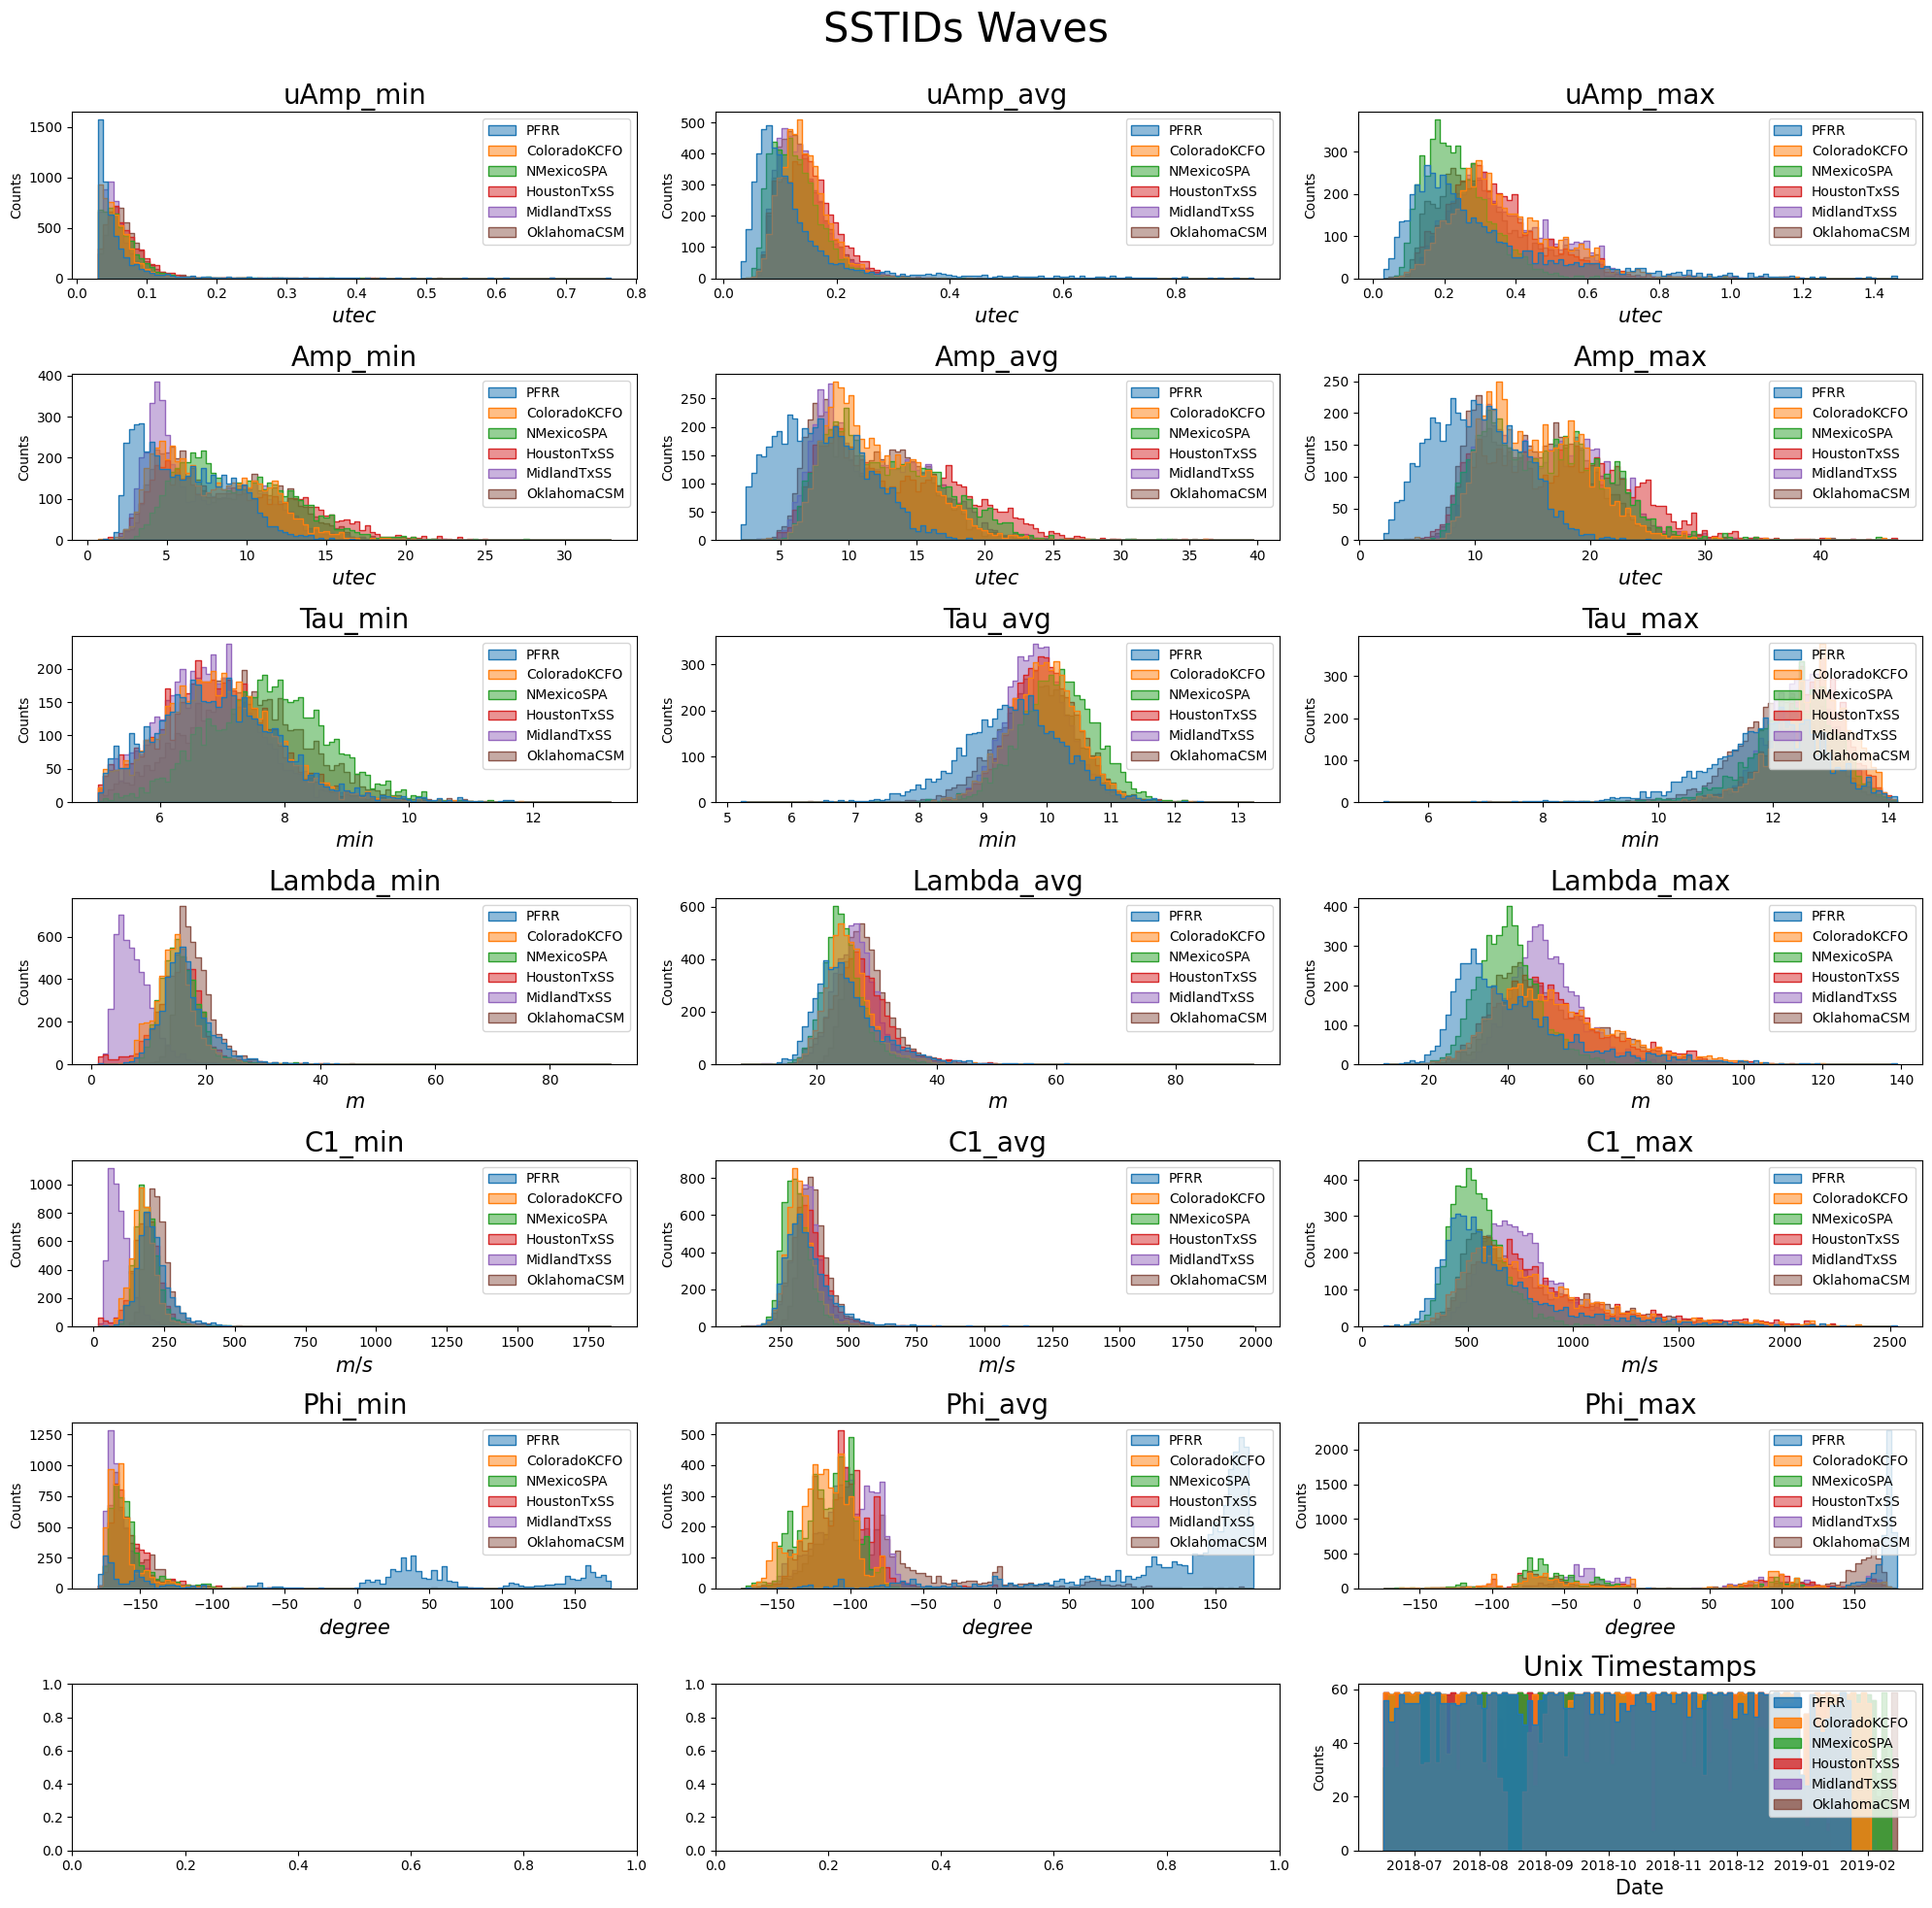

Output Data Structure:
    PFRR: [
        drivers: shape=(5000, 31)
        wtecs: shape=(5000, 18)
        ctx_wtecs: shape=(5000, 1, 18)
        utc: shape=(5000,)
        location: PFRR
        tid_type: SSTIDs
        dataset_name: SSTIDs_PFRR
    ColoradoKCFO: [
        drivers: shape=(5000, 31)
        wtecs: shape=(5000, 18)
        ctx_wtecs: shape=(5000, 1, 18)
        utc: shape=(5000,)
        location: ColoradoKCFO
        tid_type: SSTIDs
        dataset_name: SSTIDs_ColoradoKCFO
    NMexicoSPA: [
        drivers: shape=(5000, 31)
        wtecs: shape=(5000, 18)
        ctx_wtecs: shape=(5000, 1, 18)
        utc: shape=(5000,)
        location: NMexicoSPA
        tid_type: SSTIDs
        dataset_name: SSTIDs_NMexicoSPA
    HoustonTxSS: [
        drivers: shape=(5000, 31)
        wtecs: shape=(5000, 18)
        ctx_wtecs: shape=(5000, 1, 18)
        utc: shape=(5000,)
        location: HoustonTxSS
        tid_type: SSTIDs
        dataset_name: SSTIDs_HoustonTxSS
    Midlan

In [4]:
# Select location and TID type to load
locations = ['PFRR', 'ColoradoKCFO', 'NMexicoSPA', "HoustonTxSS", "MidlandTxSS", "OklahomaCSM"]
tid_type = "SSTIDs"
dataset_name = f'{tid_type}_{tid_type}'

# Select start time and load samples
start_utc = datetime.datetime(year=2018, month=6, day=16).timestamp()
data = load_wtec_h5(tid_type=tid_type, locations=locations, n_samples=5000, start_utc=start_utc, n_context=1)

# Plot TEC wave parameter distributions
util.plot_wtec_data(data)

# # Display data structure
print(f'Output Data Structure:')
for loc in locations:
    print(f'    {loc}: [')
    for k, d in data[loc].items():
          print(f'        {f"{k}: shape={d.shape}" if isinstance(d, np.ndarray) else f"{k}: {d}"}')

# wTEC GAN
Like the HFP GAN, we created a similar more simplified wTEC GAN, which aims to generate historically accurate transient ionospheric disturbances, i.e. atmospheric waves, using the datasets described above. Unlike the HFP GAN the wTEC GAN is only conditioned on the external drivers when generating wave parameters and thus doesn't require an altitude based transformer for conditioning. Since each dataset has slightly different atmospheric characteristics we trained wTEC GAN for each specific dataset. We also experimented training a single regional wTEC model to characterize atmospheric waves across an entire region, but we will talk about that later in the demo.

### Generating TEC Waves

To generate waves given a set of external driver you can call the `generate_wtec` function, which loads in a pre-trained model when sampling new TEC waves. When calling the function set the `tid_type` argument to the TID type we want to generate and `location` argument to the location of the trained  model to load in. For example if you wanted to generate Small Scale TIDs for ColoradoKCFO you would set `location="ColoradoKCFO"` and `tid_type="SSTIDs"`. Shown below is some example code for generating SSTIDs using the Colorado model given a set of drivers we previously loaded in. Make sure to pass in the correct `tid_type` and `location` to ensure we are using the correct model and z-scaling parameters.

In [5]:
# Select location
location = "ColoradoKCFO"
tid_type = data[location]["tid_type"]

# Generate Colorado wTEC samples
G_wtecs = generate_wtec(drivers=data[location]["drivers"], tid_type=tid_type, location=location)
print(f'Generated {tid_type} Shape: {G_wtecs.shape}')


Generating SSTIDs_ColoradoKCFO Waves: 100%|██████████| 50/50 [00:00<00:00, 70.09it/s]

Generated SSTIDs Shape: (5000, 18)


We can generate the TEC waves using each locally trained model and dataset and save them to a results' dictionary to be used later during evaluation and anomaly detection. This May takes some time.

In [6]:
results = dict()
# Iterate through each location
for loc in data.keys():
    # Generate wTEC samples and save to dict
    G_wtecs = generate_wtec(drivers=data[loc]["drivers"],
                            tid_type=data[loc]["tid_type"],
                            location=loc)
    results[loc] = dict(G_wtecs=G_wtecs)

Generating SSTIDs_OklahomaCSM Waves: 100%|██████████| 50/50 [00:00<00:00, 78.98it/s]


### Evaluating Model

We can evaluate our model by comparing the distributions of wave parameters out model generated to the actual distributions from our dataset used to train the model. More over we objectively evaluate our model using the same Hellinger distance metric we used for the ISR data, which can be calculated by calling the `hellinger_scores_wtec` function. The function inputs the real and generated samples and outputs a distributions distance score for each wave parameter as well as the PDF information used to calculate the score if `return_hist_info` is set, which is shown below. Make sure to pass in the correct TID type of input wTECs to ensure the correct z-scaling is applied. For this demo we will use the kde method, so we won't have to fine tune the `n_bins` or `filter_length` input arguments, however using the kde method takes slightly longer to compute.

 We also calculate conditional Hellinger distance scores, which evaluates how well our model performs on conditional subsets of data based on the input drivers. The `condtional_wtec_scores` calculates Hellinger distance scores across N cluster subsets for each input driver and these scores are more meaningful than the overall scores.

In [8]:
# Get conditional scores for each site
for loc in tqdm.tqdm(locations, desc="Calculating Hellinger Scores"):
    # Get overall hellinger distance scores
    hel_dists, hist_info = hellinger_scores_wtec(data[loc]['wtecs'], results[loc]["G_wtecs"],
                                                 tid_type=data[loc]["tid_type"],
                                                 use_kde=True, return_hist_info=True)

    # Get conditional scores
    cond_dists = conditional_wtec_scores(drivers=data[loc]['drivers'],
                                         real_wtecs=data[loc]['wtecs'],
                                         generated_wtecs=results[loc]["G_wtecs"],
                                         tid_type=data[loc]["tid_type"],
                                         n_clusters=10,
                                         use_kde=True)
    # Save results to dict
    results[loc].update(dict(hel_dists=hel_dists, hist_info=hist_info, cond_dists=cond_dists))

Calculating Hellinger Scores: 100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


##### Colorado Results Example

You can also see the performance of the model in the plots below, which show how well the generated distributions match the real distributions for each the wave parameters. For this example we will be plotting the `avg` features, but you can select a different feature (min, avg, max) you want to see by setting the `wtec_var` argument in the plotting function. The plotting function will also plot the actual PDFs used to make the distance calculation if you pass in `hist_info`. Looking at the plots you can see the Generated distribution generally matches that of real distribution showing that model can accurately reproduce the historical distributions.

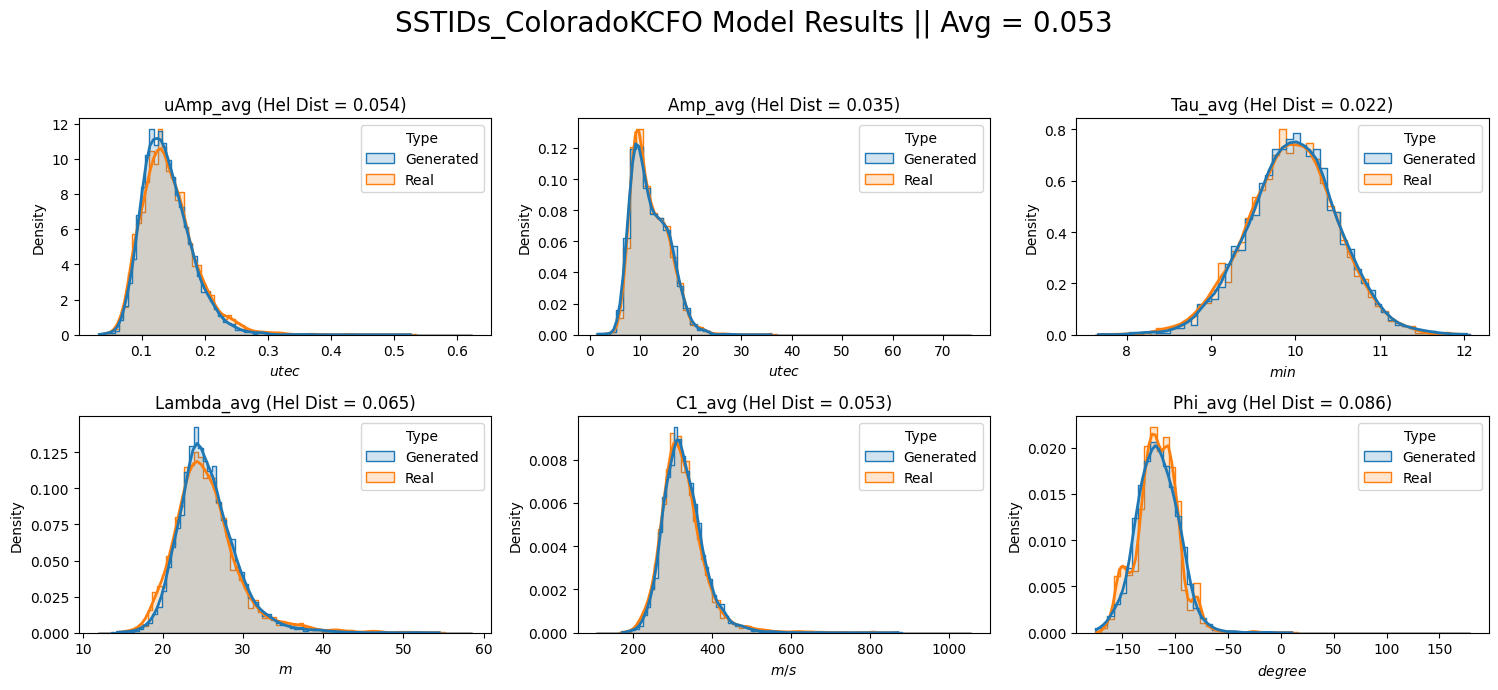

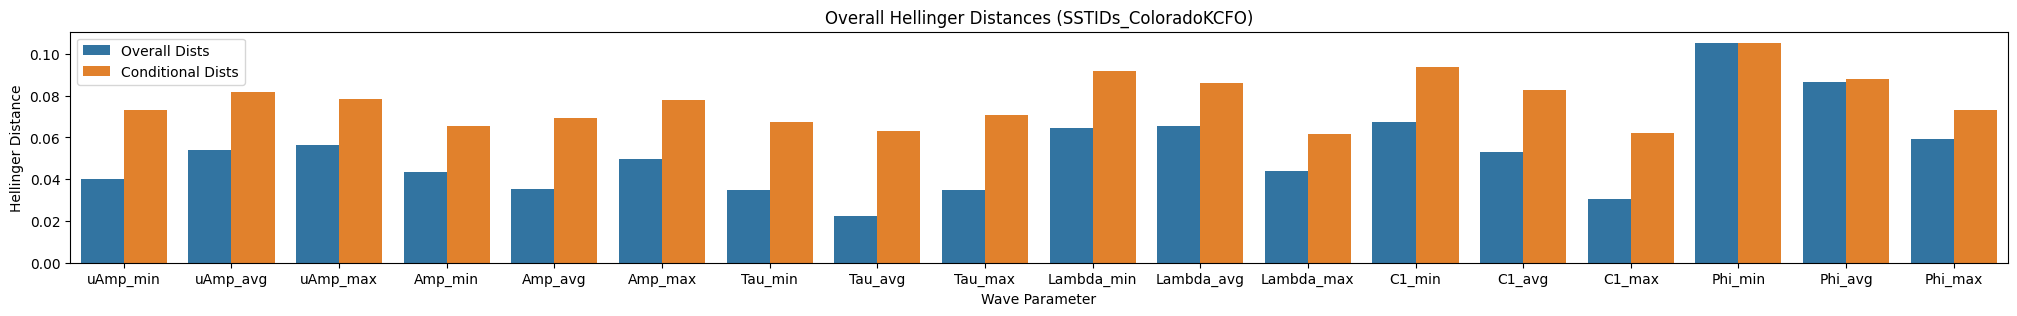

In [9]:
# Select location to evaluate
location = "ColoradoKCFO"

# Plot the real vs the generated distributions
util.plot_real_vs_generated_wtec(data[location]['wtecs'],
                                 results[location]['G_wtecs'],
                                 hel_dists=results[location]["hel_dists"],
                                 hist_info=results[location]["hist_info"],
                                 tid_type=data[location]["tid_type"],
                                 location=location,
                                 wtec_var='avg',
                                 n_bins=100)
fig, ax = plt.subplots(figsize=(25, 3))
hue = ["Overall Dists"] * len(results[location]["hel_dists"]) + ["Conditional Dists"] * len(results[location]["cond_dists"].mean(0).mean(0))
y = np.hstack((results[location]["hel_dists"], results[location]["cond_dists"].mean(0).mean(0)))
sns.barplot(y=np.hstack((results[location]["hel_dists"], results[location]["cond_dists"].mean(0).mean(0))),
            x=const.wtec_names + const.wtec_names, hue=hue, ax=ax)
ax.set_title(f"Overall Hellinger Distances ({tid_type}_{location})")
ax.set_xlabel("Wave Parameter")
ax.set_ylabel("Hellinger Distance")
plt.show()

Below shows the model's average performance across each of the conditional data splits. These scores are average across the WTEC features and locations. Note that cluster 9 contains all the samples with drivers whose' values are in the top 10%, i.e. highest in value, and cluster 0 contain samples whose drivers are in the lowest 10% for a specific feature. For example Cluster 9 for SZA contains the hellinger distance calculated from tec wave samples whose SZA drivers where in highest 10%, i.e. the subset of samples that were collect at the highest Solar Zenith Angles.

The model seem to struggle reproducing some subsets indicated by the lighter colors in the heatmap below, however for the most part the Colorado model was fairly consistent across all the subset.

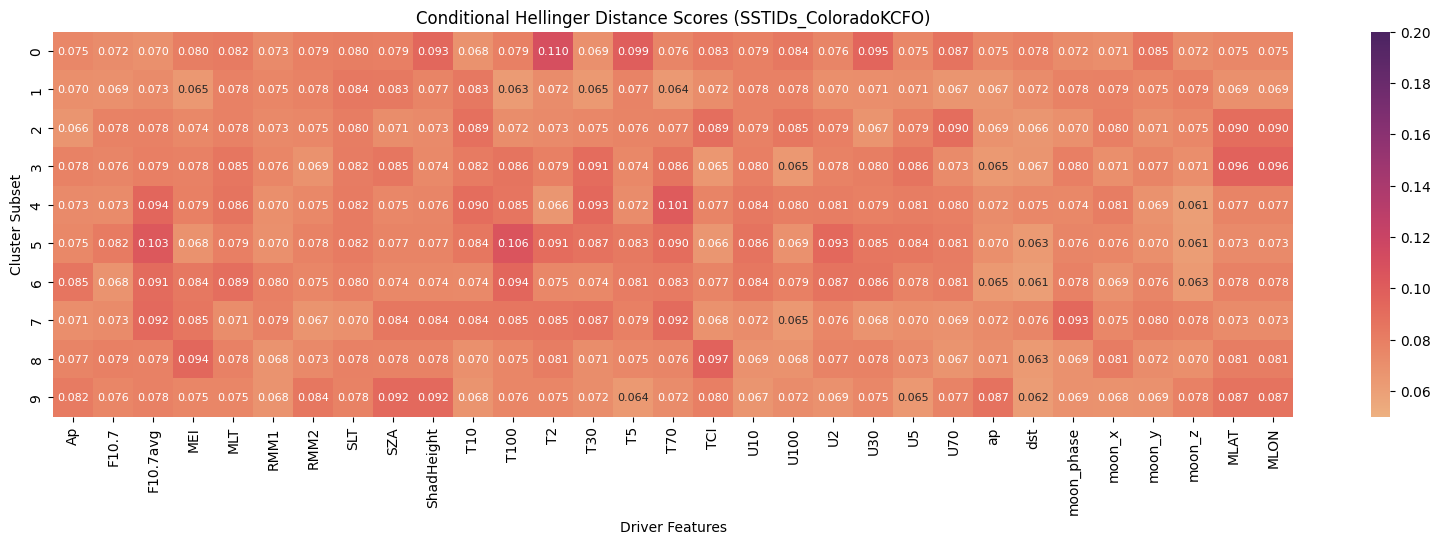

In [10]:
# Plot Average conditional Hellinger distance results across each site cluster and driver feature
fig, ax = plt.subplots(figsize=(20, 5))
vmin, vmax = 0.05, 0.2
z = results[location]["cond_dists"].mean(-1).T
sns.heatmap(z, yticklabels=np.arange(10), annot=True, fmt=".3f", annot_kws=dict(fontsize=8),
            xticklabels=const.wtec_dr_names, cmap='flare', vmin=vmin, vmax=vmax)
ax.set_ylabel("Cluster Subset")
ax.set_xlabel("Driver Features")
ax.set_title(f"Conditional Hellinger Distance Scores ({tid_type}_{location})" )
plt.show()
plt.close(fig)

##### Comparing Location Results

We can plot all the Hellinger scores on a heatmap to compare each model's performance across locations for each variable, which is shown below. Below are some take away points from the plots:

 - THe conditional scores are slightly higher than the overall scores, which is to be expected since it the conditional distributions are likely to be more narrow than the overall making it a harder problem
 - All the models tend to struggle reproducing the wave propagation direction (Phi), but do a fairly good job with all the other parameters.
 - The Poker Flat (PFRR) model did not perform as well as the other models

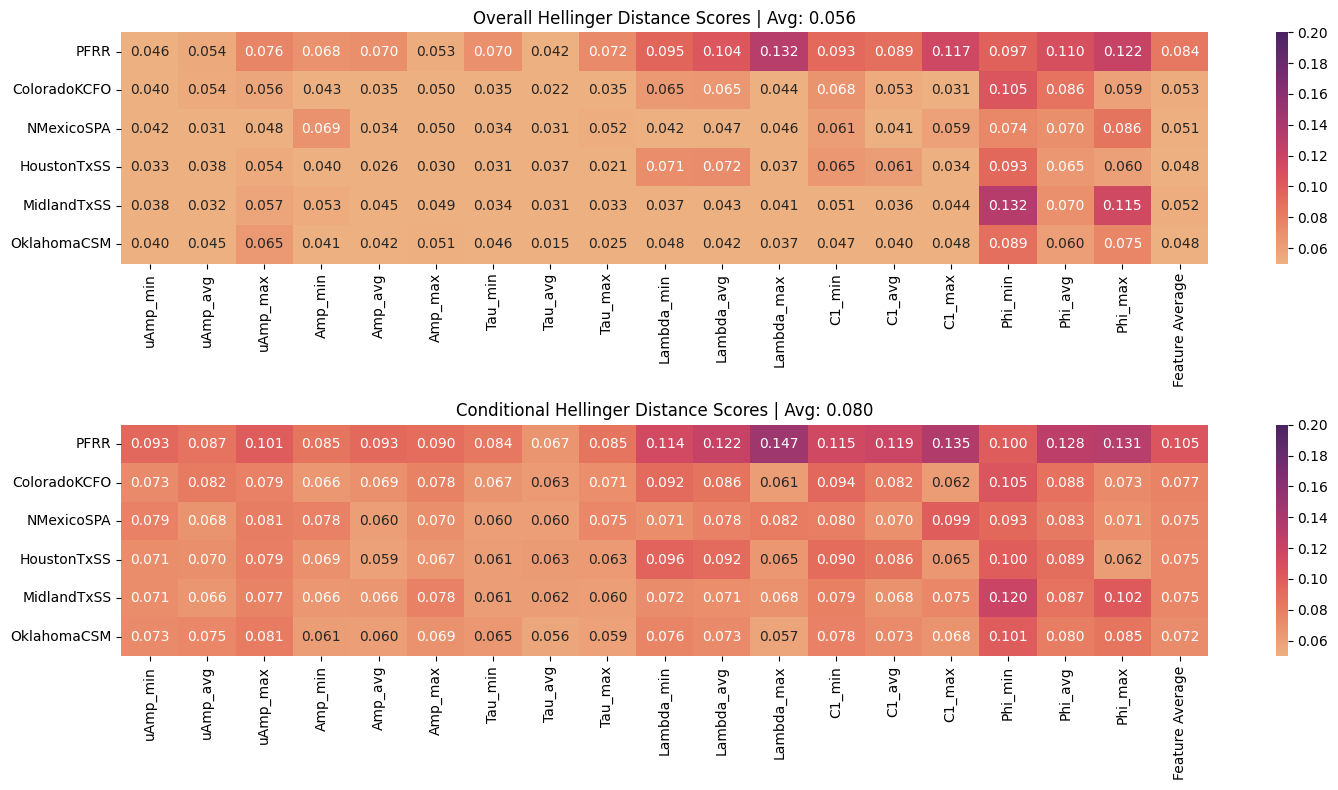

In [11]:
# Plot Hellinger distance results across each site and variable
fig, ax = plt.subplots(2, figsize=(15, 8))
plt_args = dict(xticklabels=const.wtec_names + ["Feature Average"],
                yticklabels=locations, cmap='flare', vmin=0.05, vmax=0.2, annot=True, fmt=".3f")
z = (np.vstack([np.hstack((results[loc]["hel_dists"], [results[loc]["hel_dists"].mean()])) for loc in  locations]),
     np.vstack([np.hstack((results[loc]["cond_dists"].mean(0).mean(0), [results[loc]["cond_dists"].mean()])) for loc in  locations]))
sns.heatmap(z[0], ax=ax[0], **plt_args)
ax[0].set_title(f"Overall Hellinger Distance Scores | Avg: {z[0].mean():.3f}")
sns.heatmap(z[1], ax=ax[1], **plt_args)
ax[1].set_title(f"Conditional Hellinger Distance Scores | Avg: {z[1].mean():.3f}")
plt.tight_layout()
plt.show()
plt.close(fig)

## TEC Wave anomaly scores

 We can use the same techniques previously explained in the ISR demo to estimate anomaly scores for the observations in the TEC wave dataset. We first generate a distribution of samples, say 250 samples, for each particular timestamp you want to calculate an anomaly score for. To generate the samples for each driver we call the `generate_multi_wtec` function passing in the drivers as conditioning. The multi generate function will produce  (n_samples, n_repeat, n_wtec). To get better results you should increase the `n_repeat` parameter. Good `n_repeat` values range between 1,000 and 10,000 however, to speed things up for this demo we will only be estimating anomaly scores for the first 50 samples and setting `n_repeat=250`.

##### Houston Example

In [12]:
# Select location to estimate anomaly scores for
location = "HoustonTxSS"

# Generate 50 samples for each input driver
G_wtecs = generate_multi_wtec(drivers=data[location]["drivers"][:50], n_repeat=250,
                              tid_type=data[location]["tid_type"], location=location, verbose=1)
print(f'Sampled {data[location]["tid_type"]} wTECs shape: {G_wtecs.shape}')

Sampling SSTIDs_HoustonTxSS Waves: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]

Sampled SSTIDs wTECs shape: (50, 250, 18)


Once you have generated a distribution of waves parameters for each timestamp or sample you can pass them into the `anomaly_score_wtec` function, which will perform the same joint anomaly score estimation that is performed with the ISR data. The `anomaly_score_wtec` function will estimate an anomaly score for each input sample based on the generated distribution from our model. You can see that the anomaly score function returns a score for each of the 50 input samples and the average score sits around zero. A negative score represents an anomalous sample whereas a positive score is considered to be a normal sample.

In [13]:
# Estimate anomaly score from generated samples and save to dict
anomaly_scores = anomaly_score_wtec(data[location]['wtecs'][:50], G_wtecs, tid_type=data[location]["tid_type"], alpha=3.0)
print(f"Anomaly Score Shape: {anomaly_scores.shape} | Average Score: {anomaly_scores.mean():.3f}")

Anomaly Score Shape: (50,) | Average Score: -0.254


##### All Locations

We can repeat this process across all the locations for the SSTIDs, using the code below and save the results off to be used later. THe multi generation function may take some time to complete so for this demo we will only estimate anomaly scores for the first 250 sample of each dataset and only generate 300 samples per sample. To increase the processing speed you can use GPUs, lower the number of samples, and/or the number of samples to generate.

In [14]:
for loc in locations:
    # Generate 250 samples for each input driver
    G_wtecs = generate_multi_wtec(drivers=data[loc]["drivers"][:250], n_repeat=300,
                                  tid_type=data[loc]["tid_type"], location=loc, verbose=1)

    # Estimate anomaly score from generated samples and save to dict
    results[loc]["anomaly_scores"] = anomaly_score_wtec(data[loc]['wtecs'][:250], G_wtecs,
                                                        tid_type=data[loc]["tid_type"], alpha=3.0)


Sampling SSTIDs_OklahomaCSM Waves: 100%|██████████| 2/2 [00:11<00:00,  5.95s/it]


Below there are various plots showing the resulting anomaly score distributions across each site as well as the anomaly scores Vs time. Remember, the lower the score the more anomalous the observation is. You can see that most of the scores sit around a score of 0, but there are couple samples that show up in the left tail of the distribution with high anomaly scores around -15. Note that these results are just for a much smaller subset of the overall datasets, which contain over 60,000 samples per location. You can get more samples by increasing `n_samples` argument when loading in the data.

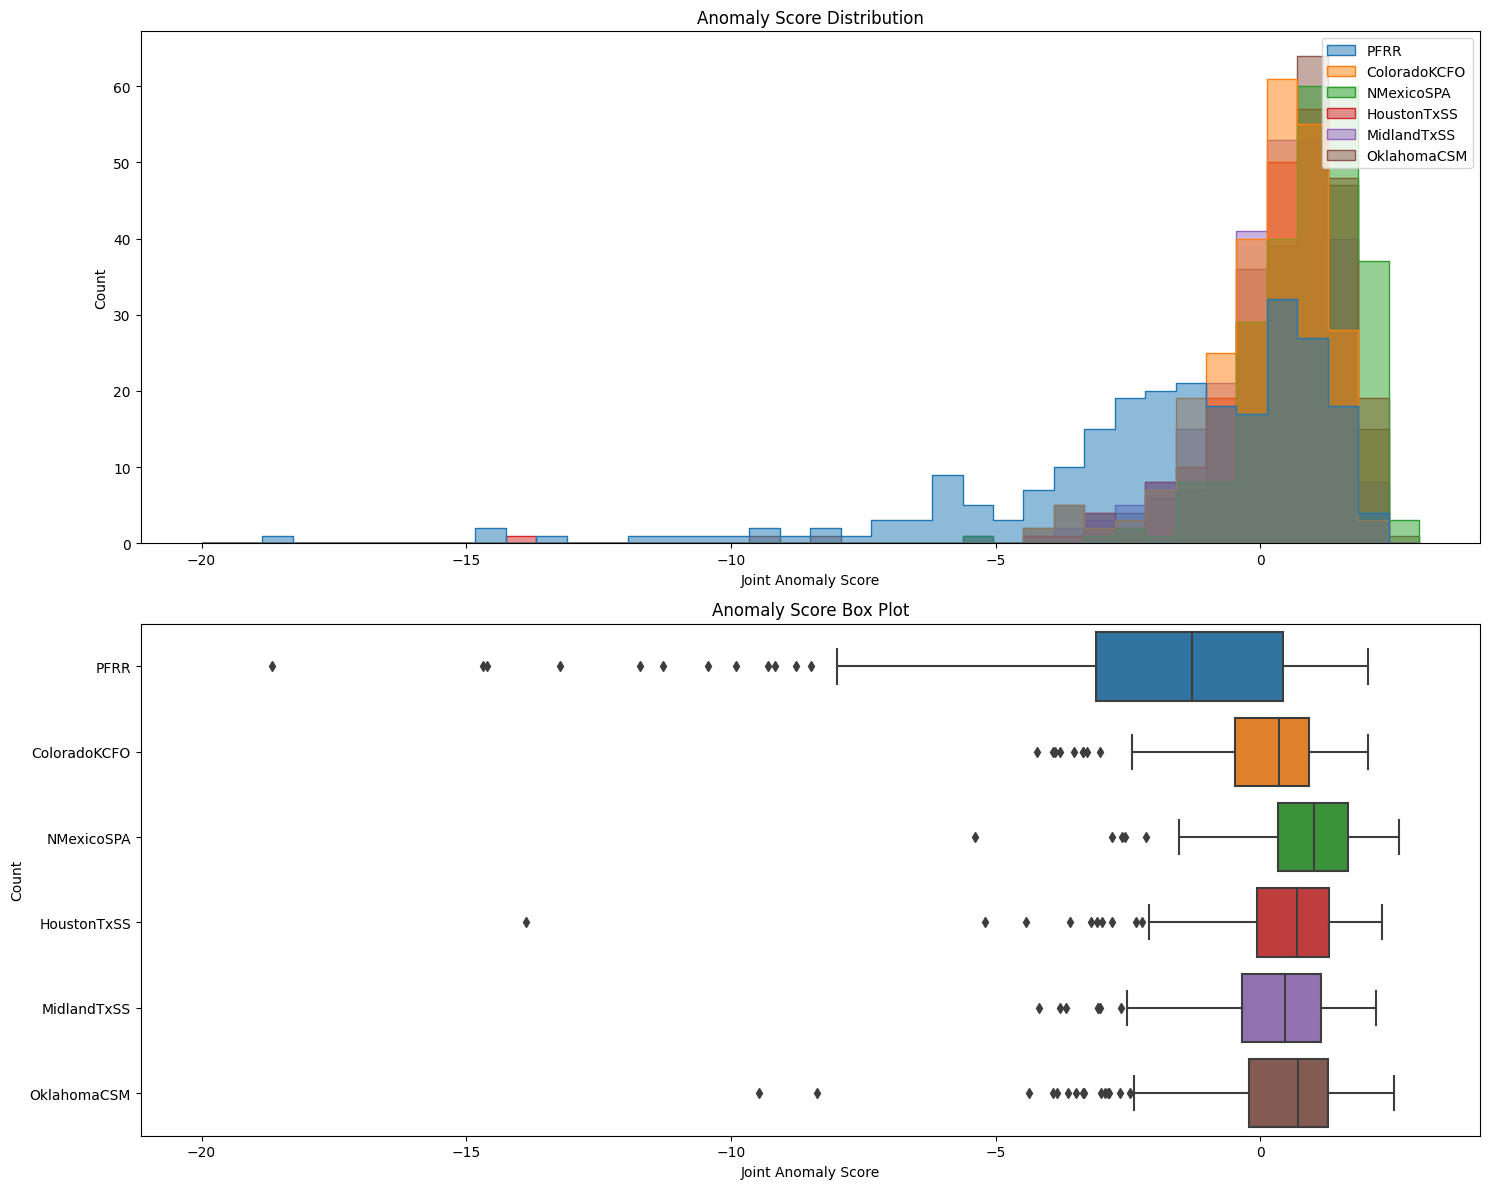

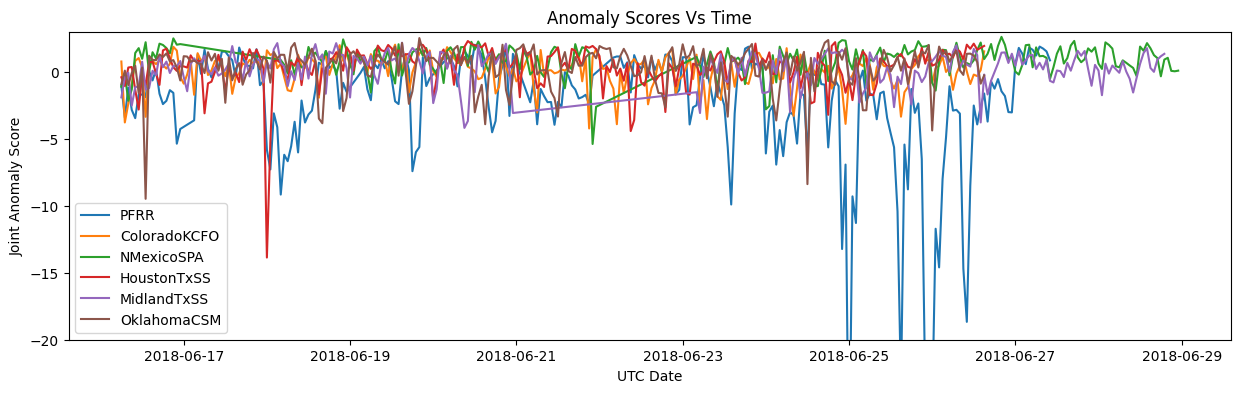

In [15]:
# Plot distribution of estimated anomaly scores for each site
fig, ax = plt.subplots(2, figsize=(15, 12))
loc_lbl, dates = [], []
for loc in locations:
        loc_lbl += [f"{loc}"] * len(results[loc]["anomaly_scores"])
        dates.extend([datetime.datetime.utcfromtimestamp(t) for t in data[loc]["utc"][:len(results[loc]["anomaly_scores"])]])
sns.histplot(x=np.hstack([results[loc]["anomaly_scores"] for loc in locations]), bins=40,
             hue=loc_lbl, ax=ax[0], element='step', alpha=0.5, binrange=(-20, 3))
ax[0].set_xlabel('Joint Anomaly Score')
ax[0].set_ylabel('Count')
ax[0].set_title(f'Anomaly Score Distribution')
sns.boxplot(x=np.hstack([results[loc]["anomaly_scores"] for loc in locations]), y=loc_lbl, ax=ax[1])
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_xlabel('Joint Anomaly Score')
ax[1].set_ylabel('Count')
ax[1].set_title(f'Anomaly Score Box Plot')
plt.tight_layout()
plt.show()
plt.close(fig)

# Plot Anomaly scores Vs Time
fig, ax = plt.subplots(figsize=(15, 4))
sns.lineplot(x=dates, y=np.hstack([results[loc]["anomaly_scores"] for loc in locations]), hue=loc_lbl, ax=ax)
ax.set_ylim(-20, 3)
ax.set_xlabel('UTC Date')
ax.set_ylabel('Joint Anomaly Score')
ax.set_title(f'Anomaly Scores Vs Time')
plt.show()
plt.close(fig)

##  Regional Model

One of the motivations for generating multiple datasets of TEC waves across various locations was to see if we could generalize our wTEC GAN to operate on a more global scale. In other words we wanted to see if we could train a more general model that could characterize the atmosphere across a range of locations instead of just a specific site. As a proof of concept we choose to collect TEC data from 5 different locations in the South West and see if our machine learning techniques and methods would generalize to different locations. The Regional model is also the same as the individually trained models expect for the regional model in is conditioned on the sample's location (latitude and longitude) in addition to the drivers. Since the regional model use the same architecture they can use the same generation and anomaly score functions as we did for the Individual models showed eariler.

The current retained regional model that we will load in was trained with data from 4 of the 5 Southwest datasets with the holdout dataset being used for testing how well our model can generalize. The goal is to train a regional model from the following 4 locations and see if it is also able to characterize the TEC waves from the Holdout test dataset.
- Training Sites:
    - ColoradoCFO
    - NMexicoSPA
    - HoustonTxSS
    - OklahomaCMS
- Test Sites
    - MidlandTxSS

###  Evaluating Regional Model

We can generate wTEC waves using the regional model bt calling the `generate_wtec` using the same data we loaded in earlier and setting `location="SouthWest"` and calculate how well the regional model performed for each location using the Hellinger distance metric. We can also call the same `hellinger_scores_wtec` and `conditional_wtec_scores` functions to get overall and conditional Hellinger distance metrics.


In [16]:
# Select the regional SSTID SouthWest model
region = "SouthWest"
tid_type = "SSTIDs"

# Declare the train and testing locations
region_locations = ['ColoradoKCFO', 'NMexicoSPA', "HoustonTxSS", "OklahomaCSM", "MidlandTxSS"]
regional_results = {}

# Get results for each dataset split
for i, loc in enumerate(region_locations):
    # Select data from the train split and generate samples using region model
    G_wtecs = generate_wtec(drivers=data[loc]["drivers"], tid_type=data[loc]["tid_type"], location=region)

    # Calculate Difference between real and generated distributions using Hellinger Distance
    hel_dists, hist_info = hellinger_scores_wtec(data[loc]['wtecs'], G_wtecs, tid_type=data[loc]["tid_type"],
                                                 z_scale=False, z_scale_inputs=False, use_kde=True, return_hist_info=True)

    # Calculate Difference between real and generated conditional distributions using Hellinger Distance
    cond_dists = conditional_wtec_scores(drivers=data[loc]['drivers'],
                                         real_wtecs=data[loc]['wtecs'],
                                         generated_wtecs=G_wtecs,
                                         tid_type=data[loc]["tid_type"],
                                         n_clusters=10,
                                         use_kde=True)
    # Save results to dict
    regional_results[loc] = dict(G_wtecs=G_wtecs, hel_dists=hel_dists, hist_info=hist_info, cond_dists=cond_dists)

Generating SSTIDs_SouthWest Waves: 100%|██████████| 50/50 [00:00<00:00, 771.64it/s]


We can plot all the Hellinger scores on a heatmap to compare the model's performance across locations for each variable, which is shown below. Some takeaways from the plots include:
 - The regional model seems to do well on data it was trained
 - Struggles to characterize many of the 'max' and 'min' features from the test or holdout dataset (MidlandTxSS)
 - Model performed fairly well the 'avg' features from the holdout dataset
 - The conditional scores showed similar trends to the Overall scores.

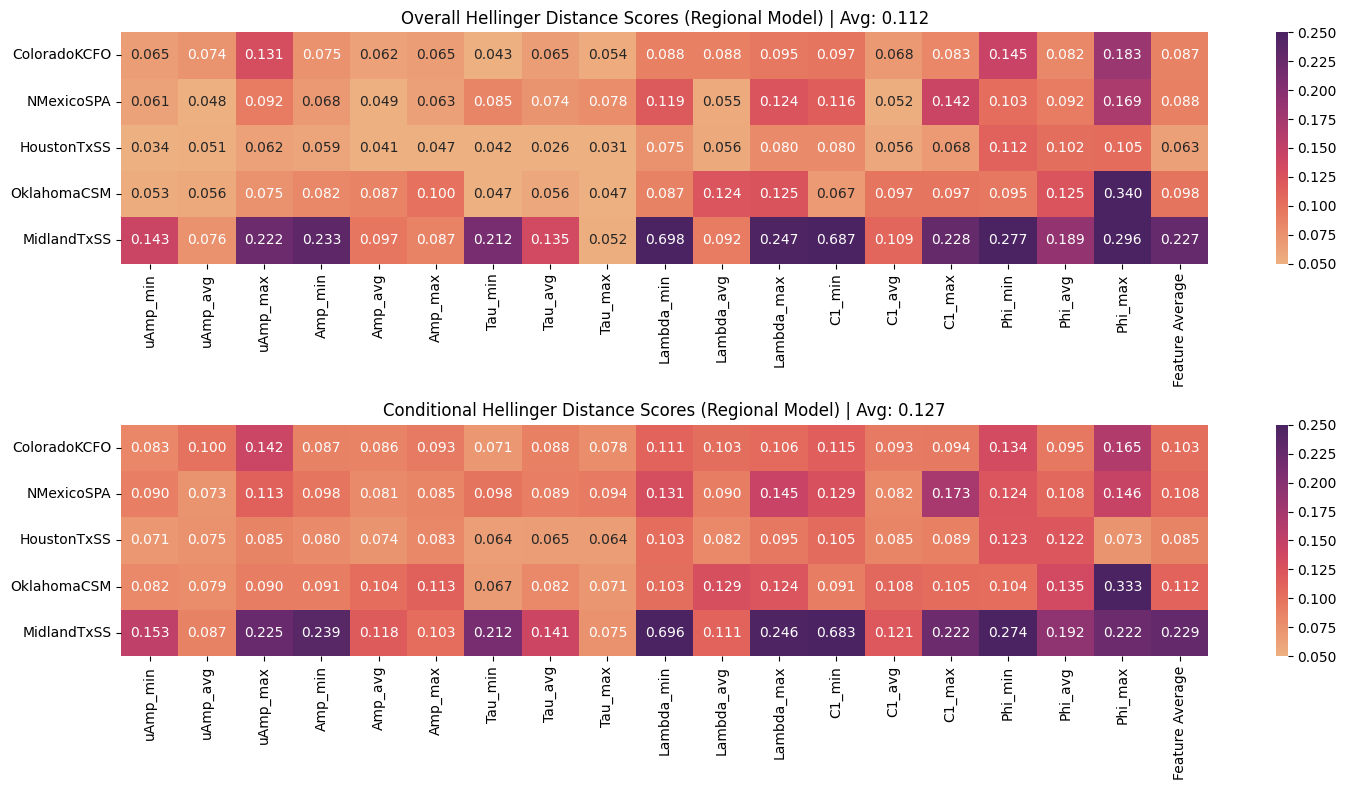

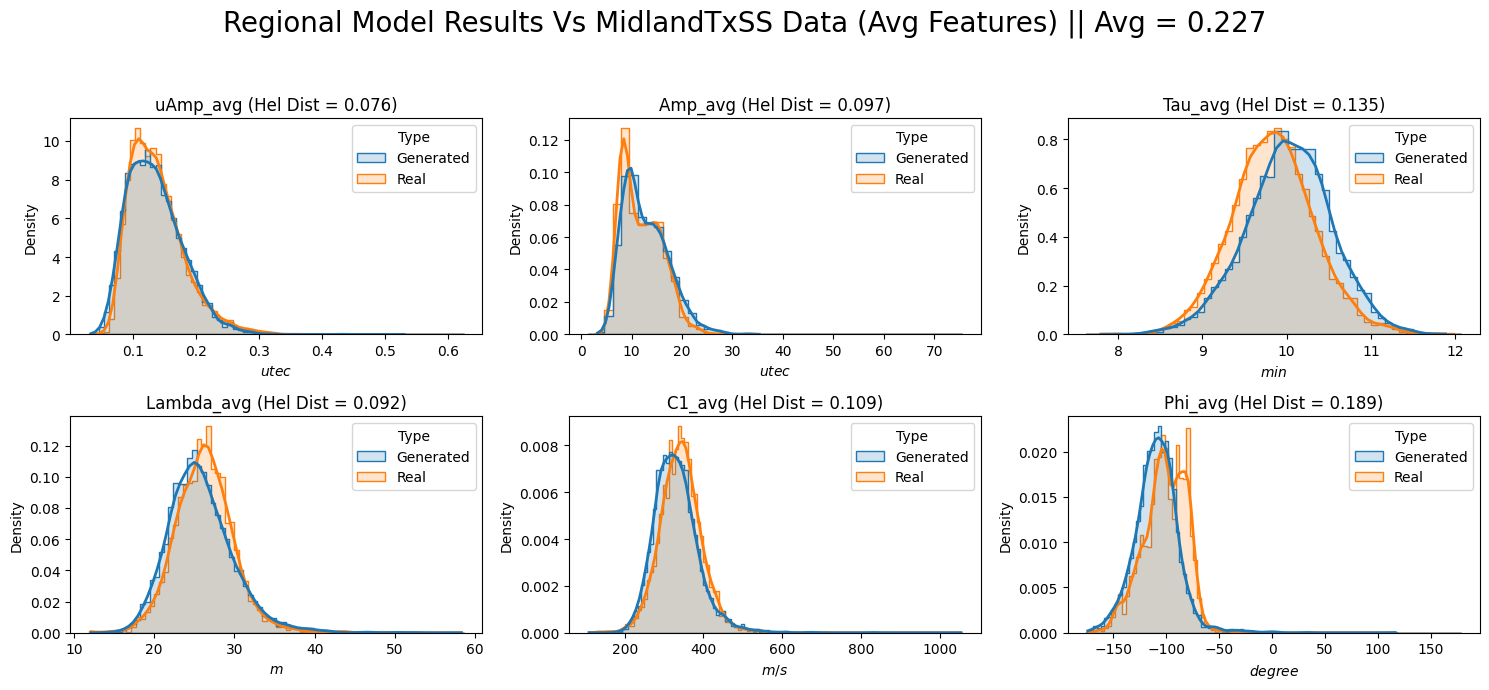

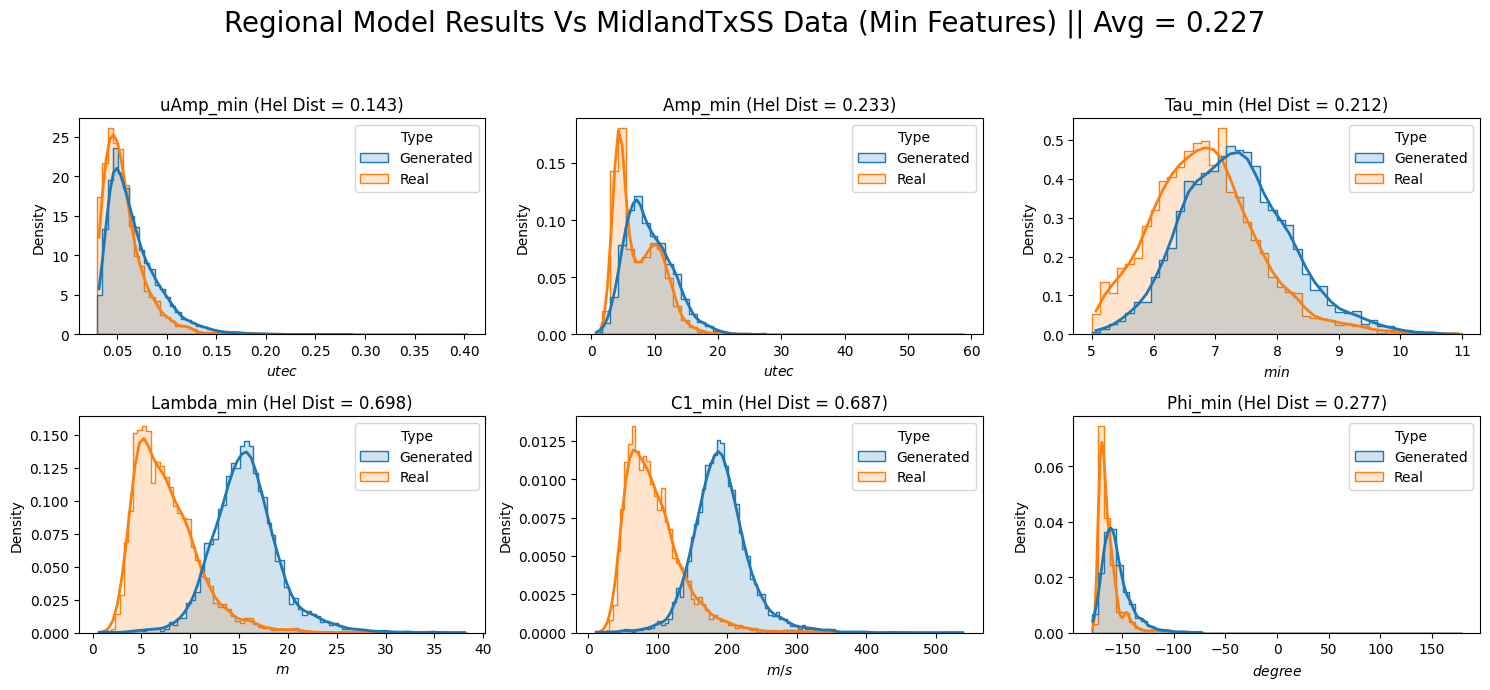

In [17]:
# Plot Hellinger distance results across each site and variable
fig, ax = plt.subplots(2, figsize=(15, 8))
plt_args = dict(xticklabels=const.wtec_names + ["Feature Average"],
                yticklabels=region_locations, cmap='flare', vmin=0.05, vmax=0.25, annot=True, fmt=".3f")
z = (np.vstack([np.hstack((regional_results[loc]["hel_dists"], [regional_results[loc]["hel_dists"].mean()])) for loc in  region_locations]),
     np.vstack([np.hstack((regional_results[loc]["cond_dists"].mean(0).mean(0), [regional_results[loc]["cond_dists"].mean()])) for loc in  region_locations]))
sns.heatmap(z[0], ax=ax[0], **plt_args)
ax[0].set_title(f"Overall Hellinger Distance Scores (Regional Model) | Avg: {z[0].mean():.3f}")
sns.heatmap(z[1], ax=ax[1], **plt_args)
ax[1].set_title(f"Conditional Hellinger Distance Scores (Regional Model) | Avg: {z[1].mean():.3f}")
plt.tight_layout()
plt.show()
plt.close(fig)

test_location = "MidlandTxSS"
util.plot_real_vs_generated_wtec(real=data[test_location]["wtecs"],
                                 generated=regional_results[test_location]["G_wtecs"],
                                 hel_dists=regional_results[test_location]["hel_dists"],
                                 hist_info=regional_results[test_location]["hist_info"],
                                 tid_type=tid_type,
                                 location=test_location,
                                 n_bins=100,
                                 title_annot=f'Regional Model Results Vs {test_location} Data (Avg Features)',)
util.plot_real_vs_generated_wtec(real=data[test_location]["wtecs"],
                                 generated=regional_results[test_location]["G_wtecs"],
                                 hel_dists=regional_results[test_location]["hel_dists"],
                                 hist_info=regional_results[test_location]["hist_info"],
                                 tid_type=tid_type,
                                 location=test_location,
                                 wtec_var='min',
                                 n_bins=100,
                                 title_annot=f'Regional Model Results Vs {test_location} Data (Min Features)')

Below shows the model's average performance across each of the conditional data splits. These scores are average across the WTEC features and locations. Note that cluster 9 contains all the samples with drivers whose' values are in the top 10%, i.e. highest in value, and cluster 0 contain samples whose drivers are in the lowest 10% for a specific feature. For example Cluster 9 for SZA contains the hellinger distance calculated from tec wave samples whose SZA drivers where in highest 10%, i.e. the subset of samples that were collect at the highest Solar Zenith Angles. Some takeaways for this heatmap are:
 - Regional model struggles to characterize data when the Solar Zenith Angle (SZA) and ShadeHeight are at very high or very low angles
 - Regional model sightly struggles when the T10, T100, ... T70  features are of average value
 - Regional model struggle across all or most of the solar local time (SLT) and magnetic local time (MLT) subset clusters
 - Regional model performance is mostly not as good a individual model performance

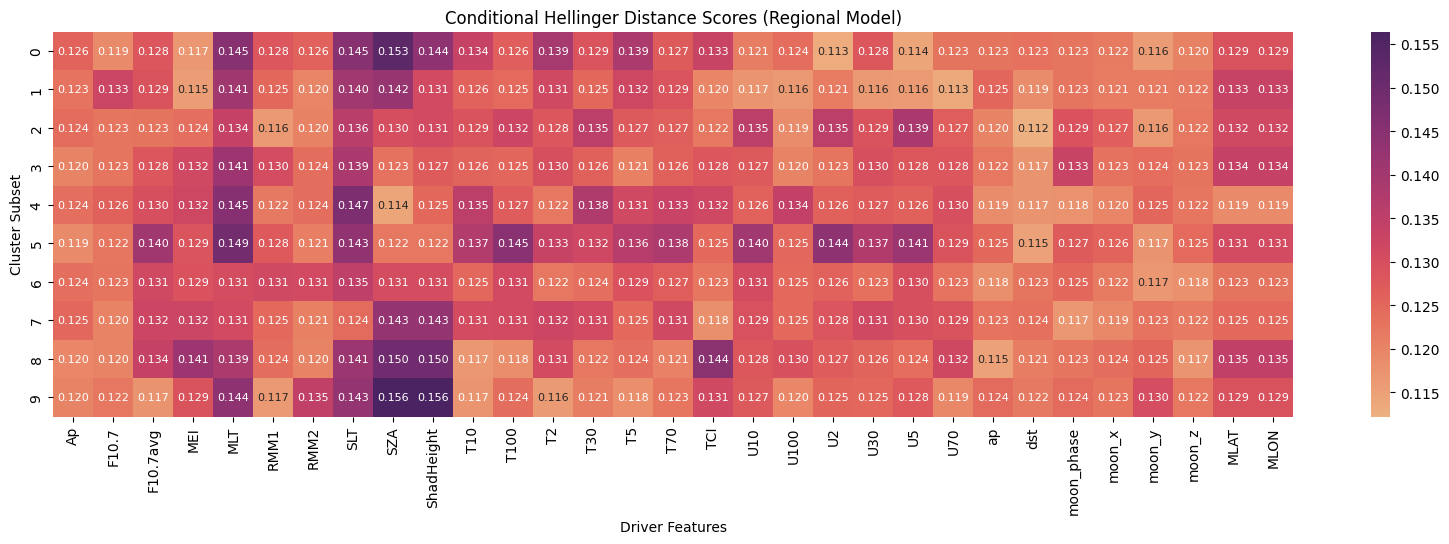

In [18]:
# Plot Average conditional Hellinger distance results across each site cluster and driver feature
fig, ax = plt.subplots(figsize=(20, 5))
vmin, vmax = 0.05, 0.25
z = np.stack([regional_results[loc]["cond_dists"].mean(-1) for loc in  region_locations]).mean(0).T
sns.heatmap(z, yticklabels=np.arange(10), annot=True, fmt=".3f", annot_kws=dict(fontsize=8),
            xticklabels=const.wtec_dr_names, cmap='flare')
ax.set_ylabel("Cluster Subset")
ax.set_xlabel("Driver Features")
ax.set_title("Conditional Hellinger Distance Scores (Regional Model)" )
plt.show()
plt.close(fig)

## WTEC Context Model

The GAN models we have been using to generating TEC Waves have so far have only been conditioned on our set of geophysical drivers. These drivers don't include any temporal information about the previous atmospheric state and thus limits our model's ability to incorporate any potential temporal dependencies found in the data. Including temporal information as context when generating TEC waves could result in a model more capable of capturing the evolution of atmospheric conditions over time and characterizing normal TEC wave behavior based on previous wave conditions.

To investigate the effects of including temporal information as context we created a slightly updated wTEC GAN, which in addition to using the geophysical drivers as conditioning also uses the previous TEC wave from 2 hours in the past as conditioning when generating the current TEC wave. As you might have noticed earlier the data dictionary we loaded at the very start also includes a variable named `ctx_wtecs`, which contains the previous wave samples found in the `wtecs` field. We currently only have models trained using 1 sample as temporal context thus the shape of `ctx_wtecs = (n_samples, 1, n_wtec)` as shown below for the Poker Flat dataset.

In [19]:
print(f'Context wTECs Shape: (n_samples, n_context, n_wtec) --> {data["PFRR"]["ctx_wtecs"].shape}')

Context wTECs Shape: (n_samples, n_context, n_wtec) --> (5000, 1, 18)


##### Southwest Region Example

Generating and evaluating the context model can be done in the same manner as we did for the standard models that had no temporal conditioning, however this time make sure to pass in the context wtecs into the `wtec_context` field of the generation function.

In [20]:
# Select the regional SSTID SouthWest model
region = "SouthWest"
tid_type = "SSTIDs"

# Declare the train and testing locations
region_locations = ['ColoradoKCFO', 'NMexicoSPA', "HoustonTxSS", "OklahomaCSM", "MidlandTxSS"]
regional_context_results = {}

# Get results for each dataset split
for i, loc in enumerate(region_locations):
    # Select data from the train split and generate samples using region model
    G_wtecs = generate_wtec(drivers=data[loc]["drivers"], tid_type=data[loc]["tid_type"],
                            ctx_wtecs=data[loc]["ctx_wtecs"], location=region)

    # Calculate Difference between real and generated distributions using Hellinger Distance
    hel_dists, hist_info = hellinger_scores_wtec(data[loc]['wtecs'], G_wtecs, tid_type=data[loc]["tid_type"],
                                                 z_scale=False, z_scale_inputs=False, use_kde=True, return_hist_info=True)

    # Calculate Difference between real and generated conditional distributions using Hellinger Distance
    cond_dists = conditional_wtec_scores(drivers=data[loc]['drivers'],
                                         real_wtecs=data[loc]['wtecs'],
                                         generated_wtecs=G_wtecs,
                                         tid_type=data[loc]["tid_type"],
                                         n_clusters=10,
                                         use_kde=True)
    # Save results to dict
    regional_context_results[loc] = dict(G_wtecs=G_wtecs, hel_dists=hel_dists, hist_info=hist_info, cond_dists=cond_dists)

Generating SSTIDs_SouthWest Waves: 100%|██████████| 50/50 [00:00<00:00, 660.20it/s]


Looking at the same heatmap plots for the context and standard models we can the following takeaways
- General increase in performance when using the context models, which is expected since we are given the model additional information when prediction samples
- Context model saw significant improvement on holdout dataset (Standard Model: 0.227 --> Context Model: 0.169), i.e. temporal context makes the model more generalizable

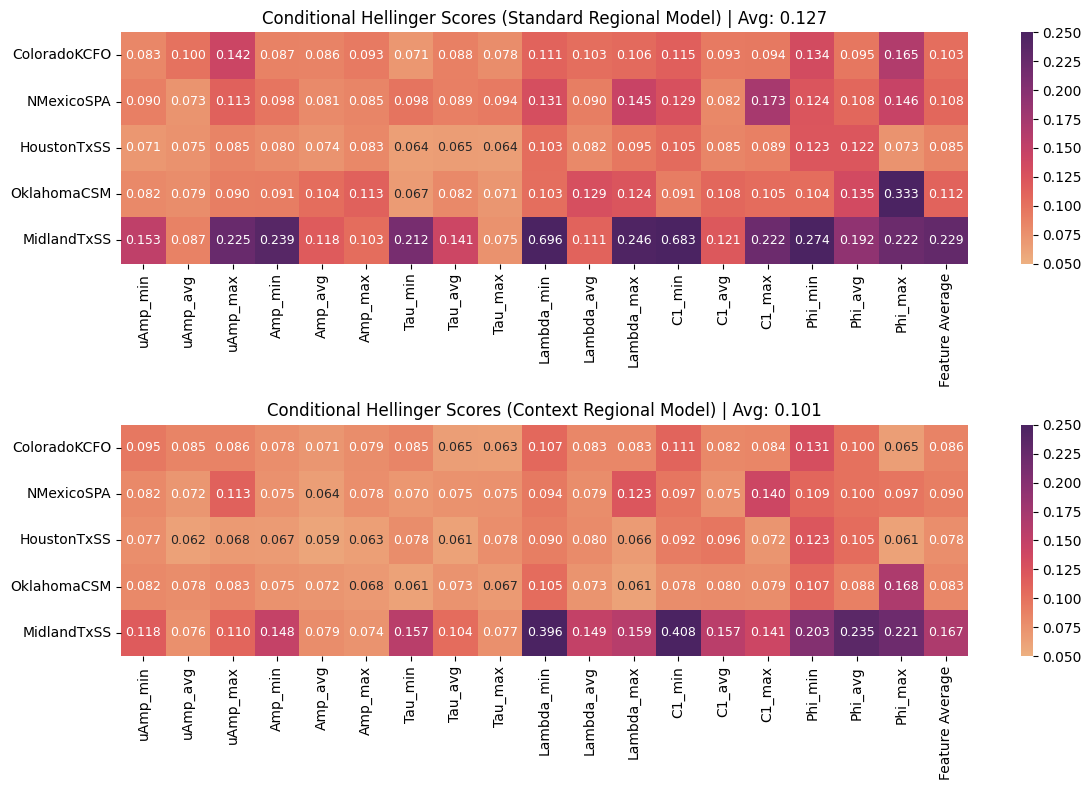

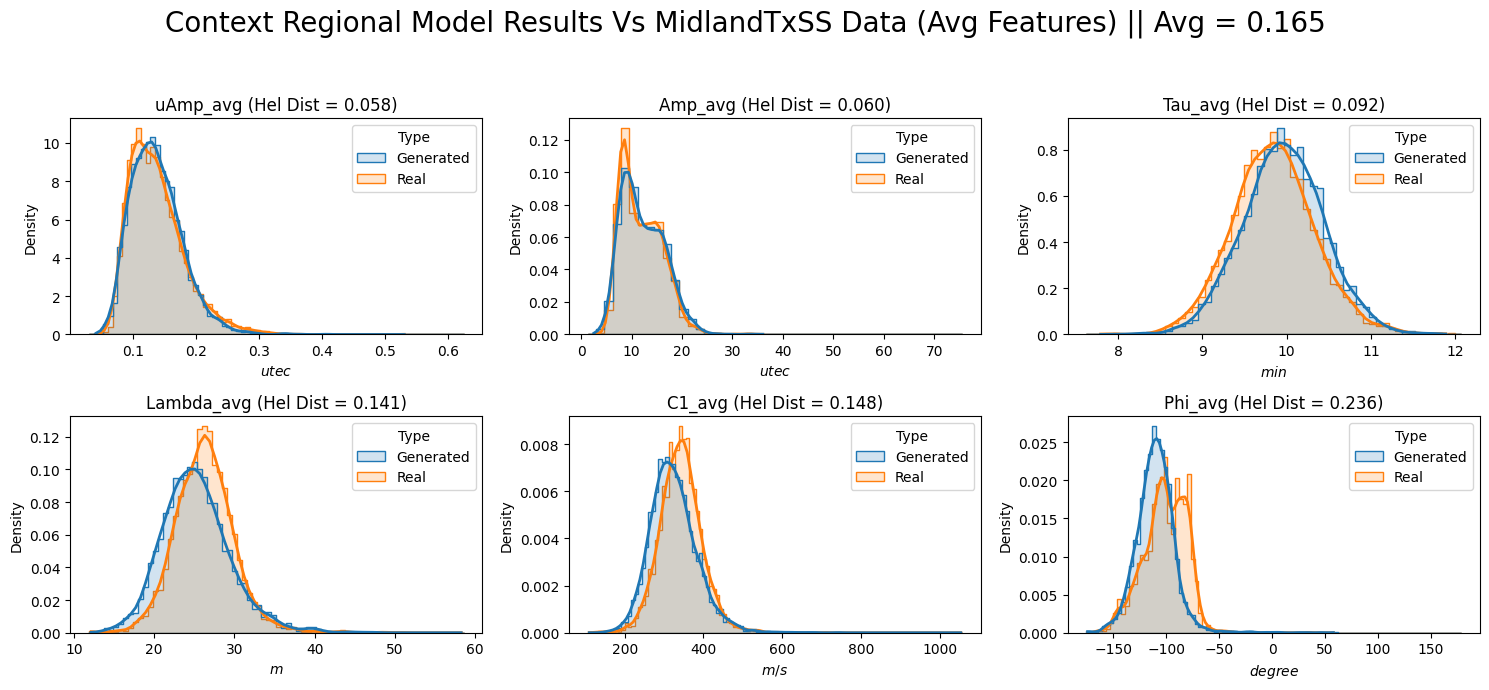

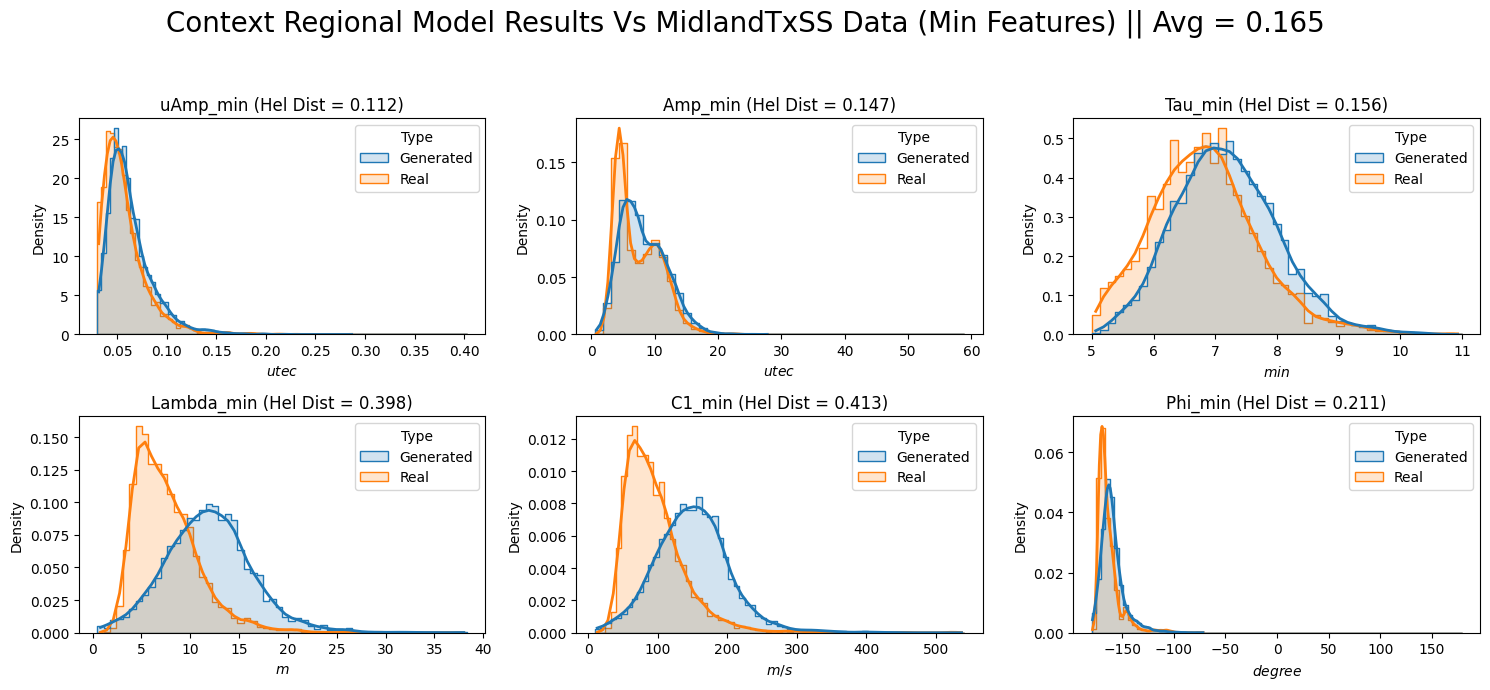

In [21]:
# Plot Hellinger distance results across site and variable
fig, ax = plt.subplots(2, figsize=(12, 8))
plt_args = dict(xticklabels=const.wtec_names + ["Feature Average"], yticklabels=region_locations, cmap='flare',
                vmin=0.05, vmax=0.25, annot_kws=dict(fontsize=9), annot=True, fmt=".3f")
z = np.vstack([np.hstack((regional_context_results[loc]["cond_dists"].mean(0).mean(0),
                          [regional_context_results[loc]["cond_dists"].mean()])) for loc in  region_locations])
sns.heatmap(z, ax=ax[1], **plt_args)
ax[1].set_title(f"Conditional Hellinger Scores (Context Regional Model) | Avg: {z.mean():.3f}")
z = np.vstack([np.hstack((regional_results[loc]["cond_dists"].mean(0).mean(0),
                          [regional_results[loc]["cond_dists"].mean()])) for loc in  region_locations])
sns.heatmap(z, ax=ax[0], **plt_args)
ax[0].set_title(f"Conditional Hellinger Scores (Standard Regional Model) | Avg: {z.mean():.3f}")
plt.tight_layout()
plt.show()
plt.close(fig)

test_location = "MidlandTxSS"
util.plot_real_vs_generated_wtec(real=data[test_location]["wtecs"],
                                 generated=regional_context_results[test_location]["G_wtecs"],
                                 hel_dists=regional_context_results[test_location]["hel_dists"],
                                 hist_info=regional_context_results[test_location]["hist_info"],
                                 tid_type=tid_type,
                                 location=test_location,
                                 title_annot=f'Context Regional Model Results Vs {test_location} Data (Avg Features)')
util.plot_real_vs_generated_wtec(real=data[test_location]["wtecs"],
                                 generated=regional_context_results[test_location]["G_wtecs"],
                                 hel_dists=regional_context_results[test_location]["hel_dists"],
                                 hist_info=regional_context_results[test_location]["hist_info"],
                                 tid_type=tid_type,
                                 location=test_location,
                                 wtec_var='min',
                                 title_annot=f'Context Regional Model Results Vs {test_location} Data (Min Features)')

### Comparing Anomaly Scores (Local Vs Regional Vs Context)

In [22]:
# Estimate anomaly scores for context models
for loc in region_locations:
    # Generate standard model samples and estimate anomalies
    G_wtecs = generate_multi_wtec(drivers=data[loc]["drivers"][:250],
                                  n_repeat=600,
                                  tid_type=data[loc]["tid_type"],
                                  location=region,
                                  verbose=1)
    regional_results[loc]["anomaly_scores"] = anomaly_score_wtec(data[loc]['wtecs'][:250], G_wtecs,
                                                                 tid_type=data[loc]["tid_type"], alpha=3.0)

    # Generate context model samples and estimate anomalies
    G_wtecs = generate_multi_wtec(drivers=data[loc]["drivers"][:250],
                                  ctx_wtecs=data[loc]["ctx_wtecs"][:250],
                                  n_repeat=600,
                                  tid_type=data[loc]["tid_type"],
                                  location=region,
                                  verbose=1)
    regional_context_results[loc]["anomaly_scores"] = anomaly_score_wtec(data[loc]['wtecs'][:250], G_wtecs,
                                                                         tid_type=data[loc]["tid_type"], alpha=3.0)

Sampling SSTIDs_SouthWest Waves: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]


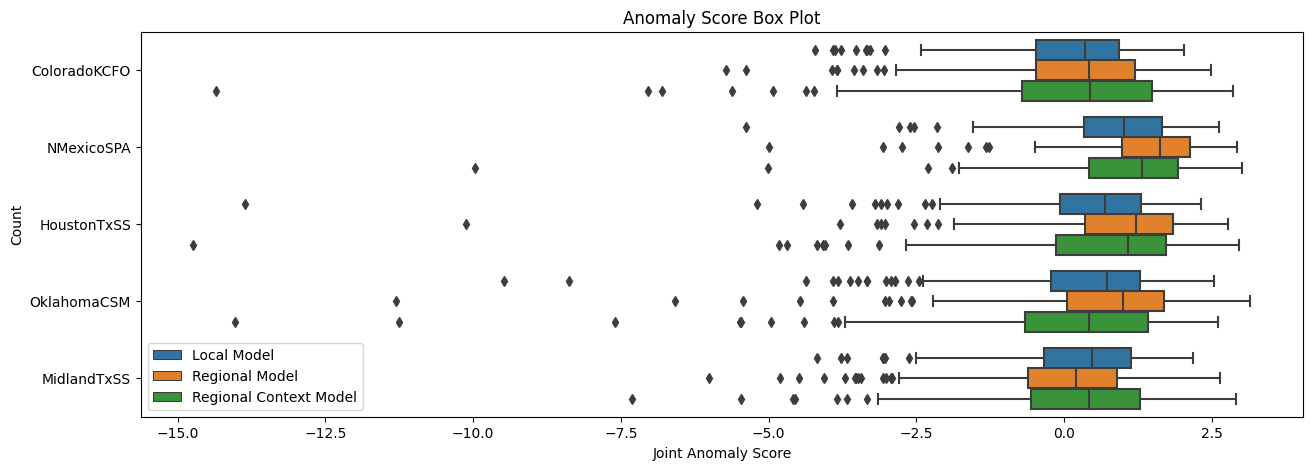

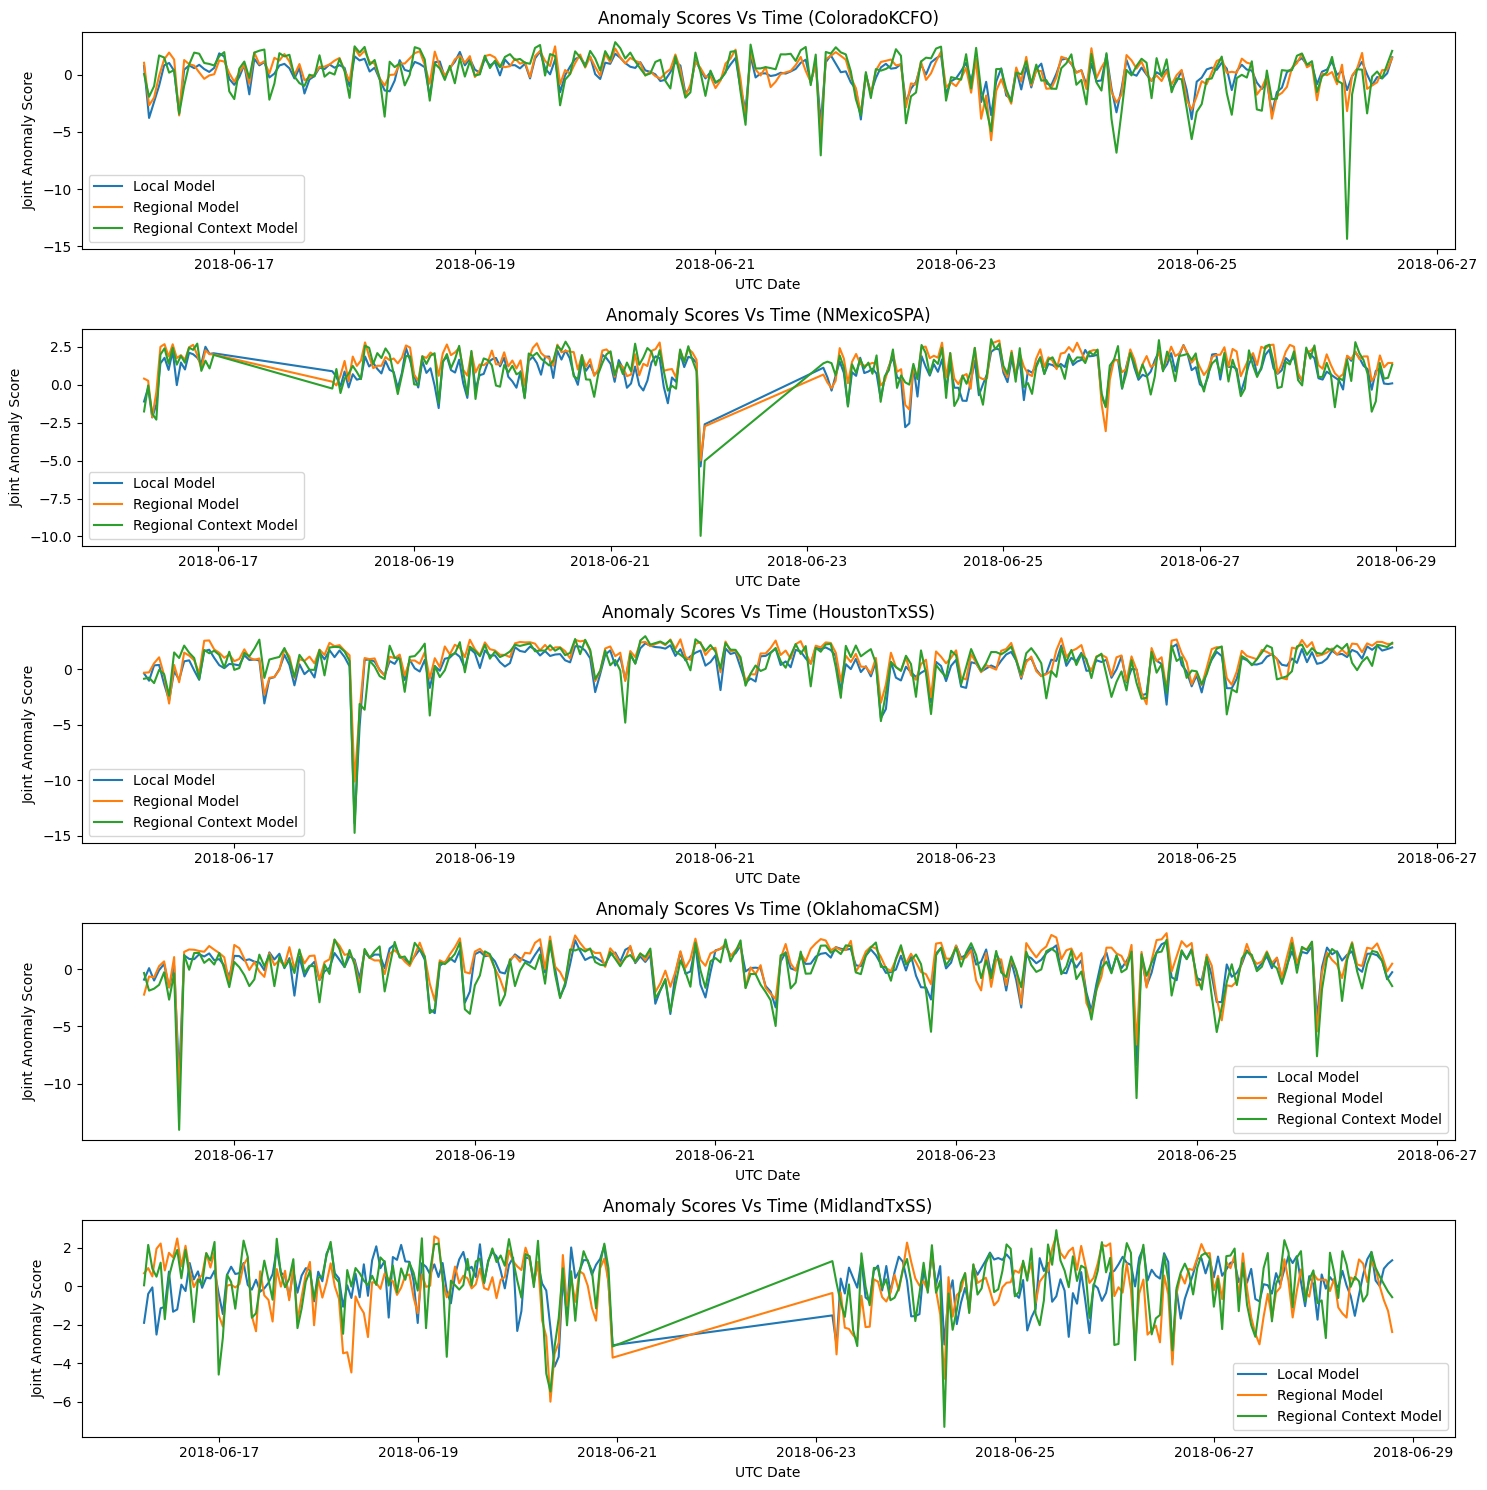

In [23]:
# Plot distribution of estimated anomaly scores for each site
fig, ax = plt.subplots(figsize=(15, 5))
loc_lbl, hue, dates = [], [], []
for loc in region_locations:
        loc_lbl += [f"{loc}"] * (len(results[loc]["anomaly_scores"]) +
                                 len(regional_results[loc]["anomaly_scores"]) +
                                 len(regional_context_results[loc]["anomaly_scores"]))
        hue += [f"Local Model"] * len(results[loc]["anomaly_scores"]) +\
               [f"Regional Model"] * len(regional_results[loc]["anomaly_scores"]) +\
               [f"Regional Context Model"] * len(regional_context_results[loc]["anomaly_scores"])
        dates.extend([datetime.datetime.utcfromtimestamp(t) for t in data[loc]["utc"][:len(regional_results[loc]["anomaly_scores"])]])
        x = np.hstack([np.hstack((results[loc]["anomaly_scores"],
                                  regional_results[loc]["anomaly_scores"],
                                  regional_context_results[loc]["anomaly_scores"]))  for loc in region_locations])
sns.boxplot(x=x, hue=hue, y=loc_lbl, ax=ax)
ax.set_xlabel('Joint Anomaly Score')
ax.set_ylabel('Count')
ax.set_title(f'Anomaly Score Box Plot')
plt.show()
plt.close(fig)

# Plot Anomaly scores Vs Time
fig, ax = plt.subplots(len(region_locations), figsize=(15, 3*len(region_locations)))
for i, loc in enumerate(region_locations):
    y = np.hstack((results[loc]["anomaly_scores"],
                   regional_results[loc]["anomaly_scores"],
                   regional_context_results[loc]["anomaly_scores"]))
    x = [datetime.datetime.utcfromtimestamp(t) for t in data[loc]["utc"][:len(results[loc]["anomaly_scores"])]] + \
        [datetime.datetime.utcfromtimestamp(t) for t in data[loc]["utc"][:len(regional_results[loc]["anomaly_scores"])]] +\
        [datetime.datetime.utcfromtimestamp(t) for t in data[loc]["utc"][:len(regional_context_results[loc]["anomaly_scores"])]]
    hue = [f"Local Model"] * len(results[loc]["anomaly_scores"]) + \
          [f"Regional Model"] * len(regional_results[loc]["anomaly_scores"]) + \
          [f"Regional Context Model"] * len(regional_context_results[loc]["anomaly_scores"])
    sns.lineplot(x=x, y=y, hue=hue, ax=ax[i])
    ax[i].set_xlabel('UTC Date')
    ax[i].set_ylabel('Joint Anomaly Score')
    ax[i].set_title(f'Anomaly Scores Vs Time ({loc})')
plt.tight_layout()
plt.show()
plt.close(fig)